# 0.Описание проекта

**Описание проекта**

Обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».
Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже.
Поэтому он просит разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. 

**Данные представлены 3-мя датасетами:**
 - ferma_main.csv. Признаки представлены следующим группами: характеристики коровы (id, Порода, порода папы_быка, Возраст), характеристики корма (ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г, СПО (Сахаро-протеиновое соотношение), характеристика пастбища (Тип пастбища), характеристики молока (Удой, кг, Жирность,%, Белок,%, Вкус молока).
 - ferma_dad.csv. Хранит имя папы каждой коровы в стаде фермера: id — уникальный идентификатор коровы, Имя Папы — имя папы коровы.
 - cow_buy.csv. Это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Содержит почти те же данные, что и ferma_main.csv, но: содержание белков и жиров в молоке указано на момент продажи — когда «ЭкоФерма» давала коровам свой корм, параметры корма ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г и СПО (Сахаро-протеиновое соотношение) отсутствуют. Технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения каждого из этих параметров на 5%. Кроме того, отсутствуют признаки Удой, кг и Вкус молока. Это целевые признаки, именно их предстоит предсказать!

**В данном проекте необходимо решить следующие задачи:**

- нужно создать две прогнозные модели для отбора бурёнок в поголовье:
  - Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
  - Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

- с помощью модели нужно отобрать коров по двум критериям:
  - средний удой за год — не менее 6000 килограммов;
  - молоко должно быть вкусным.
                                                                                                                                                  
**Структура проекта:**
 - изучение и предобработка данных,
 - исследовательский анализ,
 - корреляционный анализ признаков,
 - задача регрессии,
 - задача классификации,
 - общий вывод 

# 1.Загрузка  и изучение данных

In [1]:
#установим некоторые доп библиотеки
!pip install scikit-learn==1.1.3
!pip install phik

In [2]:
#импортируем необходимые библиотеки,отключим предупреждения (в конце), 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os # Загрузка датафрейма
import phik
import sklearn
from scipy import stats as st
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error,\
                        accuracy_score,precision_score,recall_score,confusion_matrix
import warnings
warnings.filterwarnings('ignore')

#зададим формат вывода знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

Загрузим данные из 3-х файлов и оценим их визуально

In [3]:
# функция загрузки данных из файлов
def download(file):
    
    data = pd.DataFrame()
    
    path_1 = '/datasets/' + file + '.csv'
    path_2 = 'https://code.s3.yandex.net/datasets/' + file + '.csv'
    
    if os.path.exists(path_1):
        data = pd.read_csv(path_1,sep=';')
    elif os.path.exists(path_2):
        data = pd.read_csv(path_2,sep=';')
    
    return data

In [4]:
#загрузим данные из файла с данными фермы
ferma = download('ferma_main')

#выведем первые 5 строк
ferma.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


In [5]:
#загрузим данные из файла с данными отцов коров
dad = download('ferma_dad')

#выведем первые 5 строк
dad.head()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [6]:
#загрузим данные из файла Экофермы
cow = download('cow_buy')

#выведем первые 5 строк
cow.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


Содержание таблиц соответствуют заявленным данным
Во всех датасетах мы видим, что категориальные данные записаны кириллицей  ( как названия столбцов, так и само содержание),в файле с планируемыми к покупке данными тип пастбища указан с маленькой буквы, в то время как с данными о своих коровах с большой. Также разделение целого числа и его дробной части записано через запятую, а не через точку.
Для удобства оперирования данными необходимо переименовать на латинницу как минимум названия столбцов: сделаем замену и выведем названия столбцов для каждого датасета

In [7]:
#зададим названия столбцов
columns = {
    'Удой, кг':'yield', 'ЭКЕ (Энергетическая кормовая единица)':'efu',\
             'Сырой протеин, г':'raw_protein','СПО (Сахаро-протеиновое соотношение)':'spr',\
           'Порода':'kind','Тип пастбища':'pasture','порода папы_быка':'kind_of_dad',\
           'Жирность,%':'fat_percent','Белок,%':'protein_percent','Вкус молока':'taste','Возраст':'age',\
          'Имя_папы':'dad_name','Имя Папы':'dad_name','Текущая_жирность,%':'current_fat_percent',\
         'Текущий_уровень_белок,%':'current_protein_percent'
}
#переименуем столбцы с данными фермы
ferma = ferma.rename(columns=columns)
#выведем новые названия столбцов для фермы
ferma.head(1)

,id,yield,efu,raw_protein,spr,kind,pasture,kind_of_dad,fat_percent,protein_percent,taste,age
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет


In [8]:
#переименуем столбцы с данными Экофермы
cow = cow.rename(columns=columns)
#выведем новые названия столбцов
cow.head(1)

,kind,pasture,kind_of_dad,dad_name,current_fat_percent,current_protein_percent,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет


In [9]:
#переименуем столбцы с именами отцов
dad = dad.rename(columns=columns)
#выведем новые названия столбцов
dad.head(1)

,id,dad_name
0,1,Буйный


Названия столбцов приведены к "змеинному регистру".


# 2.Предобработка данных

In [10]:
#выведем информацию о данных датасета по ферме
ferma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               634 non-null    int64 
 1   yield            634 non-null    int64 
 2   efu              634 non-null    object
 3   raw_protein      634 non-null    int64 
 4   spr              634 non-null    object
 5   kind             634 non-null    object
 6   pasture          634 non-null    object
 7   kind_of_dad      634 non-null    object
 8   fat_percent      634 non-null    object
 9   protein_percent  634 non-null    object
 10  taste            634 non-null    object
 11  age              634 non-null    object
dtypes: int64(3), object(9)
memory usage: 59.6+ KB


Данные в файле о ферме представлены данными с 634 строками, 11 столбцов с данными о характеристике коровы, характеристике корма,типе пастбища,характеристике молока. Из-за того, что разделение целого числа и его дробной части отражено запятой, а не точкой, числовой тип данных не распознается и ряд столбцов имеет некорректный формат: ЭКЕ,СПО, содержание протеина и жирность нужно привести к числовым данным.

Судя по тому, что значения в каждом столбце соответствует общему кол-ву строк, то пропуски должны отсутствовать - тем не менее проверим

In [11]:
ferma.isna().sum()

id                 0
yield              0
efu                0
raw_protein        0
spr                0
kind               0
pasture            0
kind_of_dad        0
fat_percent        0
protein_percent    0
taste              0
age                0
dtype: int64

Проверим на явные дубликаты и выведем дубликаты при наличии

In [12]:
ferma.duplicated().sum()

5

In [13]:
ferma.loc[ferma.duplicated()]

,id,yield,efu,raw_protein,spr,kind,pasture,kind_of_dad,fat_percent,protein_percent,taste,age
629,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
630,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
631,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
632,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
633,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет


Выявлено 5 дубликатов, удалим их далее, перед этим сопоставив с данными из файла с именами "отцов" коров.

Проанализируем на неявные дубликаты категориальные данные:

In [14]:
ferma['kind'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

In [15]:
ferma['pasture'].unique()

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

Выявлен неявный дубликат в названии типа пастбища, далее произведем замену "Равнинные" на "Равнинное" 

In [16]:
ferma['kind_of_dad'].unique()

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

Выявлен неявный дубликат в названии типа пастбища, далее произведем замену "Айдиалл" на "Айдиал".

Также проверим на дубликаты столбцы со вкусом и возрастом

In [17]:
ferma['taste'].unique()

array(['вкусно', 'не вкусно'], dtype=object)

In [18]:
ferma['age'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

Произведем замену неявных дубликатов в типе пастбища и породе отца, после чего снова выведем дубликаты строк

In [19]:
ferma = ferma.apply(lambda x: x.replace({'Равнинные':'Равнинное', 'Айдиалл':'Айдиал'}, regex=True))
ferma.loc[ferma.duplicated()]

,id,yield,efu,raw_protein,spr,kind,pasture,kind_of_dad,fat_percent,protein_percent,taste,age
629,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
630,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
631,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
632,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
633,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет


Кол-во дубликатов строк не увеличилось.

Далее проанализируем данные файла с именами отцов коров

In [20]:
dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   dad_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


В данных об именах отцов 629 строк(скорее всего как раз 634 строк из данных фермы минус 5 дубликатов), тип данных корректный. Проверим файл на пропуски и дубликаты

In [21]:
dad.isna().sum()

id          0
dad_name    0
dtype: int64

In [22]:
dad.duplicated().sum()

0

Пропуски и дубликаты в файле с именами коров фермы отсутствуют.

Проверим на неявные дубликаты в именах

In [23]:
dad['dad_name'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

В файле с именами отцов отсутствуют явные и неявные дубликаты.

Далее проанализируем файл с данными Экофермы

In [24]:
cow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   kind                     20 non-null     object
 1   pasture                  20 non-null     object
 2   kind_of_dad              20 non-null     object
 3   dad_name                 20 non-null     object
 4   current_fat_percent      20 non-null     object
 5   current_protein_percent  20 non-null     object
 6   age                      20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


Данные в файле с коровами Экофермы 20 строк, пропусков нет, данные столбцов с текущей жирностью и содержанием белка нужно привести к числовому типу (в них тип данных также некорректный из-за разделения целой и дробной части числа запятой, а не точкой).

Проверим на явные дубликаты и выведем эти дубликаты при наличии

In [25]:
cow.duplicated().sum()

4

In [26]:
cow.loc[cow.duplicated()]

,kind,pasture,kind_of_dad,dad_name,current_fat_percent,current_protein_percent,age
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


Присутствует 4 строки с дубликатами: при этом стоит понимать, что для датасета это дубликаты, но фактически это могут быть разные коровы, просто от одного отца, породы и с одними показателями жирности и белка в молоке, одного возраста. Поэтому, считаю, что для датасета Экофермы с коровами на продажу удалять дубликаты некорректно

Проверим на неявные дубликаты категориальные значения

In [27]:
cow['kind'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

In [28]:
cow['pasture'].unique()

array(['холмистое', 'равнинное'], dtype=object)

In [29]:
cow['age'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

В файле Экоферым неявные дубликаты отсутствуют. При работе с прогнозированием данных нужно будет привести данные по типу пастбища к одному регистру

Удалим дубликаты в файле фермы, заменим запятые на точки, приведем тип пастбища к одному регистру,после чего поменяем тип данных

In [30]:
#удалим дубликаты
ferma = ferma.drop_duplicates().reset_index(drop=True)
#поменяем запятые на точки
ferma = ferma.replace(',','.',regex=True)
cow = cow.replace(',','.',regex=True)
#приведем тип пастбища в файлах фермы и Экоферы к одному регистру
ferma['pasture'] = ferma['pasture'].str.lower()
#изменим тип данных на числовой
ferma[['efu','spr','fat_percent','protein_percent']] = \
      ferma[['efu','spr','fat_percent','protein_percent']].astype('float')
cow[['current_fat_percent','current_protein_percent']] = \
      cow[['current_fat_percent','current_protein_percent']].astype('float')
#выведем инфо по файлу фермы
ferma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               629 non-null    int64  
 1   yield            629 non-null    int64  
 2   efu              629 non-null    float64
 3   raw_protein      629 non-null    int64  
 4   spr              629 non-null    float64
 5   kind             629 non-null    object 
 6   pasture          629 non-null    object 
 7   kind_of_dad      629 non-null    object 
 8   fat_percent      629 non-null    float64
 9   protein_percent  629 non-null    float64
 10  taste            629 non-null    object 
 11  age              629 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.1+ KB


In [31]:
#выведем инфо по файлу Экофермы
cow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   kind                     20 non-null     object 
 1   pasture                  20 non-null     object 
 2   kind_of_dad              20 non-null     object 
 3   dad_name                 20 non-null     object 
 4   current_fat_percent      20 non-null     float64
 5   current_protein_percent  20 non-null     float64
 6   age                      20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


**По итогу проведенной предобработки данных:**
 - пропуски в данных отсутствуют,
 - удалены явные дубликаты, обработаны неявные дубликаты,
 - все данные приведены к корректному типу


# 3.Исследовательский анализ данных

Проведем исследовательский анализ данных.

Сначала анализ качественных данных датасета фермы: построим для них круговые диаграммы и далее проанализируем каждый признак.

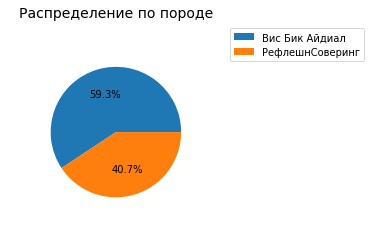

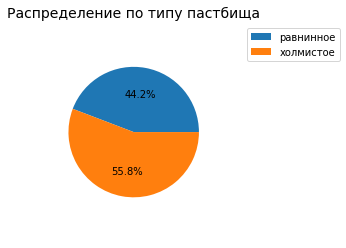

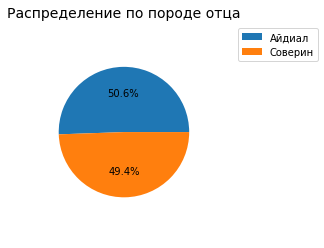

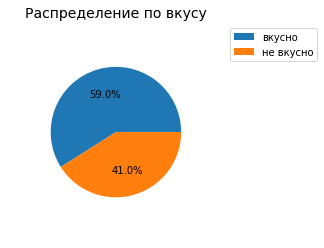

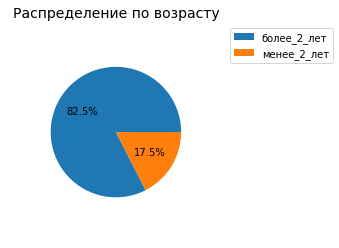

In [32]:
#создадим фукнцию для построения круговой диаграммы
def pie(df,column, title):
    plt.pie(df.groupby(column)[column].count(), autopct='%.1f%%', radius=0.75)
    plt.title(title,fontsize=14);
    plt.legend(labels = df[column].unique(),loc='upper left', bbox_to_anchor=(1.0, 1.0));
    plt.show()
categor = pd.DataFrame({'column':['kind','pasture','kind_of_dad','taste','age'],\
                        'title':['Распределение по породе','Распределение по типу пастбища',
                                 'Распределение по породе отца','Распределение по вкусу',\
                                 'Распределение по возрасту']})
#выведем круговые диаграммы на одно графике для всех данных
for index,row in categor.iterrows():
    pie(ferma,row[0],row[1])

Исходя из построенных графиков:
 - распределение по породе коров: преобладают коровы породы ВисБикАйдиал - 59%, в то время как РефлешнСоверин составляет 41%.
 - распределение по породе отца: данные практически равномерны Айдиал - 51%, Соверин - 49%.
 - распределение по типу пастбища:холмистое - 56%, равнинное-44%.
 - распределение по вкусу: коровы фермы дают больше "вкусного" молока, чем нет - 59% против 41%
 - распределение по возрасту: т.к. это молочные породы, то первое молоко начинают давать по достижению преимущественно 2-х лет (первый отел), поэтому большая доля коров в выборке - возрастом более 2-х лет(82.5%)

Проанализируем данные по количественным показателям, сначала выведем статистку

In [33]:
ferma.describe().T

,count,mean,std,min,25%,50%,75%,max
id,629.00,315.00,181.72,1.00,158.00,315.00,472.00,629.00
yield,629.00,"6,188.75","1,644.80","5,204.00","5,751.00","6,133.00","6,501.00","45,616.00"
efu,629.00,14.54,1.31,10.90,13.50,14.70,15.60,16.80
raw_protein,629.00,"1,923.36",182.96,"1,660.00","1,771.00","1,888.00","2,062.00","2,349.00"
spr,629.00,0.91,0.03,0.84,0.89,0.93,0.94,0.96
fat_percent,629.00,3.60,0.17,2.99,3.59,3.65,3.72,3.75
protein_percent,629.00,3.08,0.00,3.07,3.07,3.08,3.08,3.08


Исходя из стат данных по столбцам видим следующее:
 - удои в кг: данные находятся в диапазоне от 5204, среднее и медиана отличаются на 55 кг, присутствует нехарактерное значение в 45616 - отличие в 9 раз от медианного значения в удоях крайне маловероятно, скорее всего при заполнении данных была допущена ошибка  (проставлена лишняя цифра). Нельзя однозначно сказать, в каком месте эта лишняя цифра проставлена, при этом все значения удоев лежат в интервале от 5 тысяч кг, поэтому скорее всего лишняя цифра стоит вначале - считаю возможным не удалять значение, а скорректировать на 5616
 - ЭКЕ в диапазоне от 10.9 до 16.8, медиана не существенно отличается от среднего - выбросы либо отсутствуют, либо их немного,
 - содержание сырого протеина в корме: значения находятся в диапазоне от 1660 до 2349 грамм, среднее - 1923, медиана - 1888,
 - СПО: в диапазоне от 0.84 до 0.96,
 - жирность: в диапазоне от 2.99 до 3.75%, медиана - 3.65, среднее - 3.6,
 - содержание белка: в диапазоне от 3.069 до 3.085 %, медиана очень близка к среднему - 3.076.
 
Оценим насколько много выбивающихся значений в файле с удоем

In [34]:
ferma['yield'].sort_values(ascending=False).head()

16     45616
70      7222
135     7207
296     7201
294     7197
Name: yield, dtype: int64

Данное выбивающееся значение только 1, максимальным же значением удоя является 7222 кг. Скорректируем значение строки с 45616 на наиболее подходящее - 5616 и снова выведем статистику по столбцу

In [35]:
#скорректируем значение строки с ошибкой в удоях
ferma.loc[ferma['yield']==45616,'yield'] = 5616
#выведем обновленную статистику по столбцу с удоями
ferma['yield'].describe()

count     629.00
mean    6,125.16
std       475.91
min     5,204.00
25%     5,746.00
50%     6,132.00
75%     6,501.00
max     7,222.00
Name: yield, dtype: float64

После устранения ошибочного значения среднее ожидаемо упало.

Построим гистограммы распределения количественных признаков и диаграммы размаха. Начнем с распределения удоя

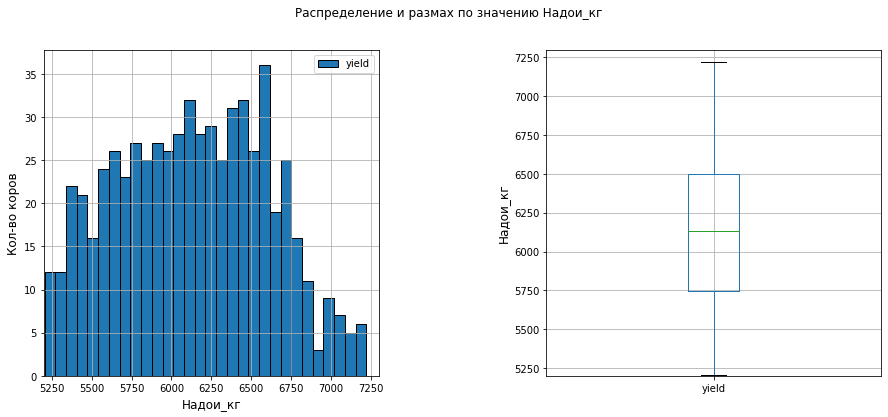

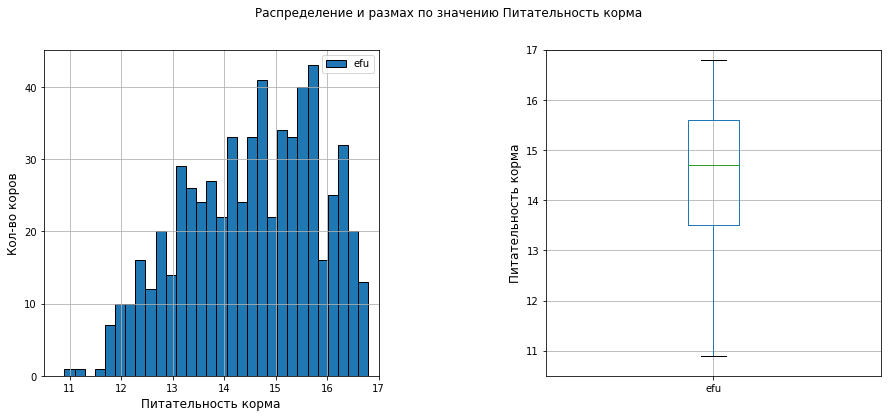

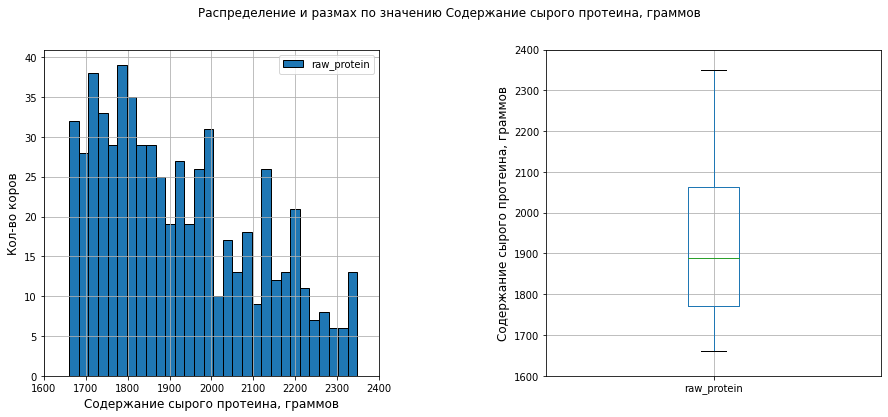

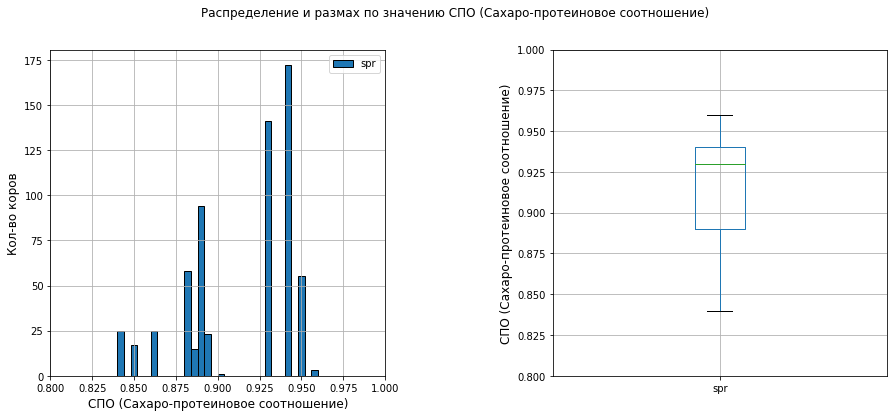

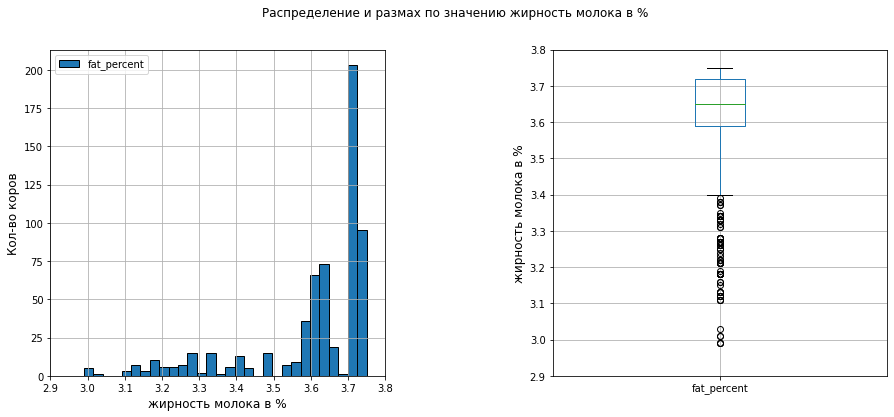

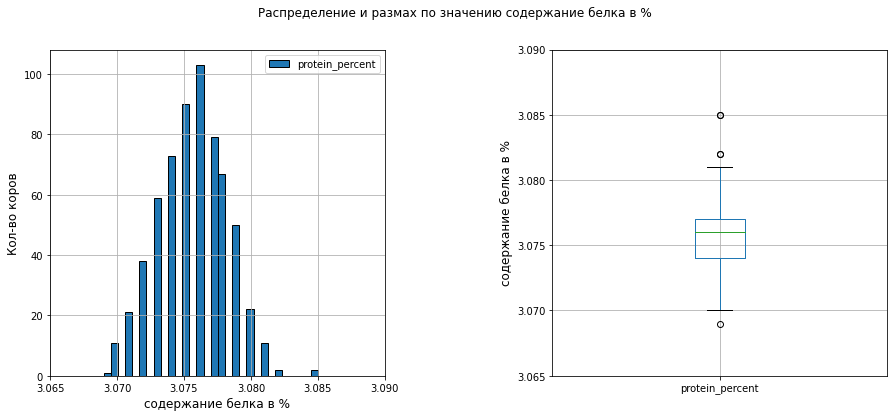

In [36]:
#создадим фукнцию для построения гистограммы распределения и диаграммы размаха
def hist_box(df,column, title,lim):
    fig, ax = plt.subplots(figsize = (20, 5))
    
    df.plot(y =column,\
          kind ='hist', ec='black', bins = 30, grid = True,figsize=(15,6),ax = plt.subplot(1, 2, 1));
    plt.ylabel('Кол-во коров', fontsize=12);
    plt.xlabel(title, fontsize=12);
    plt.xlim(lim)

    df.boxplot(column=column,ax = plt.subplot(1, 2, 2))
    plt.ylim(lim)
    plt.ylabel(title, fontsize=12);
    
    fig.suptitle('Распределение и размах по значению '+title)
    plt.subplots_adjust(wspace=0.5,hspace = 0.5)
    plt.show()

numeric = pd.DataFrame({'column' : ['yield','efu','raw_protein', 'spr',\
                                  'fat_percent', 'protein_percent'], 
                        'title' : ['Надои_кг','Питательность корма','Содержание сырого протеина, граммов',\
                                  'СПО (Сахаро-протеиновое соотношение)','жирность молока в %', \
                                 'содержание белка в %' ],
                        'lim':[(5200,7300),(10.5,17),(1600,2400),(0.8,1),(2.9,3.8),(3.065,3.09)]
                       })   
#выведем гистограмму распределения и диаграмму размаха
for index,row in numeric.iterrows():
    hist_box(ferma,row[0],row[1],row[2])

Для показателя удоев:
- Распределение напоминает "гребенку",
- Согласно гистограммы и диаграммы размаха выбросы отсутствуют (ошибочное значение 45616 мы скорректировали), надои находятся в интервале от 5204 кг до 7222кг, причем половина в интервале от 5746 до 6501 кг, медиана - 6132 кг и несущественно выше среднего значения 6125. Наиболее частое значение около 6550 кг, пиковым значением является в т.ч. 5600 кг и 6500 кг.

Для показателя питательности корма:
 - Распределение также напоминает "гребенку",
 - Согласно гистограммы и диаграммы размаха выбросы отсутствуют, ЭКЕ в диапазоне от 10.9 до 16.8, медиана 14.7 не существенно отличается от среднего - 14.54.Наиболее частое значение - около 14.7, наименее - до 11.7, пиковые интервалы на 14.6-14.7 и на 15.6-15.7, значения распределяются волнообразно

Содержание сырого протеина в корме:
 - В распределении также наблюдается много пиков, является распределением с обрывом слева,
 - Согласно гистограммы и диаграммы размаха выбросы отсутствуют, значения находятся в диапазоне от 1660 до 2349 грамм, среднее - 1923, медиана - 1888. Наиболее частое значение - около 1980.

СПО:
- Распределения является изолированным с несколькими пиками, есть три непересекающихся интервала, в которых встречаются располагаются данные,
- Согласно гистограммы и диаграммы размаха выбросы отсутствуют, значения находятся в диапазоне от 0.84 до 0.96, медиана - 0.93. Наиболее частые значения 0.935 и 0.93, наименее - 0.96

Жирность молока,%:
 - Распределение также является прерывистым, интервальным, основной интервал от 3.53 до 3.75,
 - Согласно гистограмме и диаграмме распределения мы видим, что все меньше 3.4% является выбросами, без их учета значения находятся преимущественно с интервале от 3.4% до 3.75%, медиана - 3.65%. Мода - около 3.72

Содержание белка в %:
 - Распределение показателя  имеет признаки "нормального", 
 - Согласно диаграммы размаха у значений белка очень маленький разброс. Медиана очень близка к среднему - 3.076.

Также проанализируем распределение коров по их отцу (4 отца) через круговую диаграмму

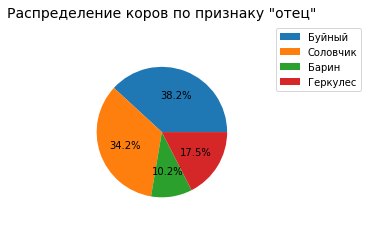

In [37]:
pie(dad,'dad_name','Распределение коров по признаку "отец"')

Наибольшее и примерно одинаковое кол-во "детей" имеют быки по кличкам Буйный и Соловчик (38 и 34% соответственно), далее идут Геркулес (17.5%) и Геркулес (10%).

**Вывод по исследовательскому анализу:**

1) Датасет по ферме:
 - Каждый категориальный признак имеет только 2 значения и распределение данных значений колеблется в интервале от 41 до 59, за исключением возраста коровы - здесь преимущественно представлен возраст свыше 2-х лет (82.5% всей выборки).

 - Аномальное значение удоев было скорректировано, причина ошибки - неверный ввод данных (лишняя цифра вначале)

 - В показателях проценты жирности молока и процент белка в молоке присутствуют выбросы, которые возможно потребуется исключить при построении модели регрессии либо трансформировать признак. Это может потребоваться, т.к. модель подстраивается под выбросы, чтобы минимизировать ошибки, и из-за этого её прогностические свойства падают.
 
 - Необходимо отметить необычное распределение почти всех признаков, кроме процента белка в молоке:
   - распределение удоев,питательности корма и сырого протеина в корме напоминает "гребенку" с некоторыми отличиями (например, распределение сырого протеина является распределением с обрывом слева),
   - распределение СПО и процента жирности является изолированным с несколькими пиками, интервальным,с обрывом справа,
   - только распределение процента белка наиболее близко к нормальному.

 - Стоит отметить, что т.к. каждая категориальная переменная имеет только 2 значения, то это сильно упрощает ее кодирование. Также, поскольку каждая количественная переменная имеет свою размерность и очень отличается от остальных, потребуется масштабирование количественных переменных. 
 
2) Датасет с именами отцов коров:
 - категориальный признак имеет 4 значения.


# 4. Корреляционный анализ признаков в датасете по ферме

## 4.1.Взаимосвязь между признаками:

Изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между всеми признаками. 

Сначала построим тепловую карту для расчета корреляции Пирсона для числовых данных

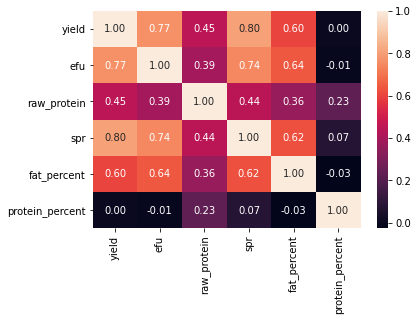

In [38]:
sns.heatmap(ferma.drop(['id'],axis=1).corr(), annot=True, fmt='.2f');

Согласно матрицы корреляции при наличии взаимосвязи - она является прямой.

Согласно матрицы корреляции наибольшая линейная зависимость удоев прослеживается с СПО - 0.8 и ЭКЕ - 0.77, она является прямой и высокой. Заметная корреляция удоев прослеживается с показателем жирности молока - 0.6, умеренная связь с содержанием сырого протеина в корме- 0.45, а с процентным содержанием белка в молоке корреляция не выявлена.

По прочим показателям:
 - ЭКЕ коррелирует с СПО - 0.74 и связь высокая, 
 - ЭКЕ коррелирует с показателем жирности молока - 0.64 и связь заметная,
 - связь ЭКЕ и содержание сырого протеина в корме является умеренной - 0.39,
 - сырой протеин в корме и СПО также умеренно коррелируют-0.44,
 - сырой протеин и жирность молока  коррелируют умеренно - 0.36,
 - СПО и жирность молока заметно корреклируют - 0.62,
 - содержание белка в молоке и сырой протеин в корме коррелируют слабо - 0.23.
 - между содержанием белка в молоке и всеми показателями, кроме сырого протеина в корме, линейная зависимость не выявлена либо очень слабая.
 
Посчитаем коэффициент корреляции Фи, который находит взаимосвязь между категориальными, порядковыми и интервальными признаками. 

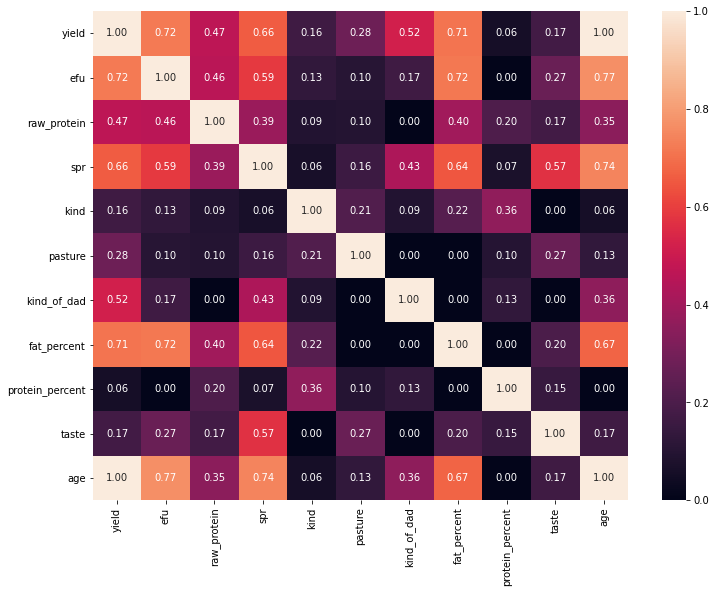

In [39]:
#построим матрицу корреляции
fig, ax = plt.subplots(figsize=(12, 9));
sns.heatmap(ferma.drop(['id'],axis=1).phik_matrix(
    interval_cols = ['yield', 'efu','raw_protein', 'spr', 'fat_percent', 'protein_percent']
),ax=ax, annot=True, fmt='.2f');

Коэф-т корреляции Фи также подтверждает полученные выше выводы о корреляции между количественными признаками, при этом сами значения немного иные:
 - удои больше всего коррелируют с ЭКЕ, процентом жирности и СПО - значения коэф-тов 0.72,0.71 и 0.66 соответственно, менее с содержанием сырого протеина - 0.47.
 - наибольшая корреляция между прочими количественными признаками: ЭКЕ и возраст - 0.77, ЭКЕ и процент жирности - 0.72, СПО и процент жирности - 0.64
При этом мы видим, что из всех признаков, включая категориальные, наибольшая корреляция удоев прослеживается с возрастом коров - 1, далее коэф-т корреляции удоев и категориальных признаков следующие (по убыванию):с породой отца коровы - 0.52,с типом пастбища - 0.28,со вкусом молока - 0.17,с породой самой коровы - 0.16.

Вкус молока, например, больше всего коррелирует с СПО - 0.57,далее с типом пастбища и ЭКЕ - 0.27, с жирностью молока - 0.2, с удоями, возрастом,и долей сырого протеина в корме - 0.17, с процентом белка в молоке - 0.15, а с породой коровы и ее отца корреляция отсутствует

## 4.2. Диаграммы рассеяния scatterplot для признака Удой, кг 

Построим диаграммы рассеяния scatterplot для признака Удой, кг и всех количественных признаков с учётом значения категориальных признаков.

### 4.2.1. Диаграммы рассеяния  для признака Удой, кг и Сырой протеин в корме

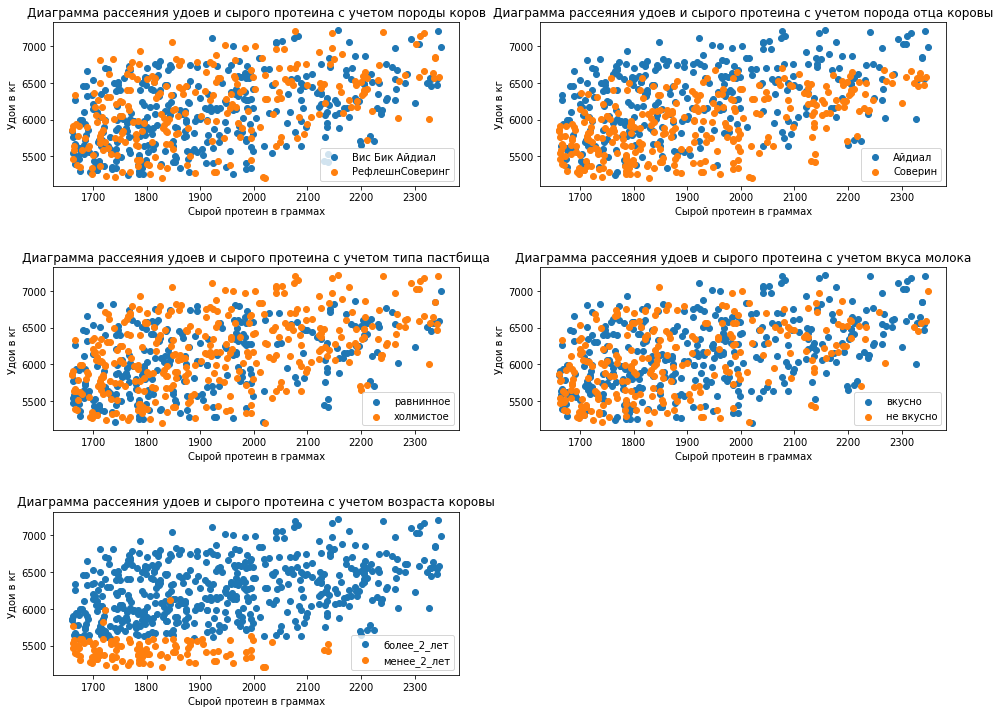

In [40]:
#напишем функцию для построения диаграммы рассеяния удоев и сырого протеина, далее будет переписывать функцию под
#каждый количественные признак
def scatter(z,title):
    groups = ferma.groupby(z)
    for name, group in groups:
        plt.scatter(group['raw_protein'], group['yield'], marker='o',label=name)
        plt.title('Диаграмма рассеяния удоев и сырого протеина с учетом ' + title)
        plt.ylabel('Удои в кг')
        plt.xlabel('Сырой протеин в граммах')
        plt.legend()
#выведем диаграмму рассения удоев и сырого протеина с учетом категориальных признаков
plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace = 0.5)
plt.subplot(3, 2, 1)
scatter('kind','породы коров')
plt.subplot(3, 2, 2)
scatter('kind_of_dad','порода отца коровы')
plt.subplot(3, 2, 3)
scatter('pasture','типа пастбища')
plt.subplot(3, 2, 4)
scatter('taste','вкуса молока')
plt.subplot(3, 2, 5)
scatter('age','возраста коровы')

Согласно диаграмме рассения удоев и сырого протеина некоторая умеренная прямая зависимость присутствует, рассмотрим в разрезе категориальных:
 - с учетом породы коров: не прослеживается существенного отличия,
 - с учетом породы отца коров: практически при любых значениях сырого протеина более высоким значениям удоев соответствует порода Айдал,
 - с учетом типа пастбища: начиная примерно с 1770 граммов сырого протеина, более высоким значениям удоев соответствует холмистый тип пастбища,
 - вкус молока: до отметки ниже 7000 кг удоев не прослеживается существенного отличия во вкусе, при этом максимальным значениям удоев при сыром протеине в размере от 1900 грамм соответствует "вкусное" молоко,
 - возраст коров: при любом значении сырого протеина для получения удоев свыше примерно 5600 кг возраст коров должен быть свыше 2-х лет, за небольшим исключением (попало 4 значения) 

### 4.2.2. Диаграммы рассеяния  для признака Удой, кг и ЭКЕ

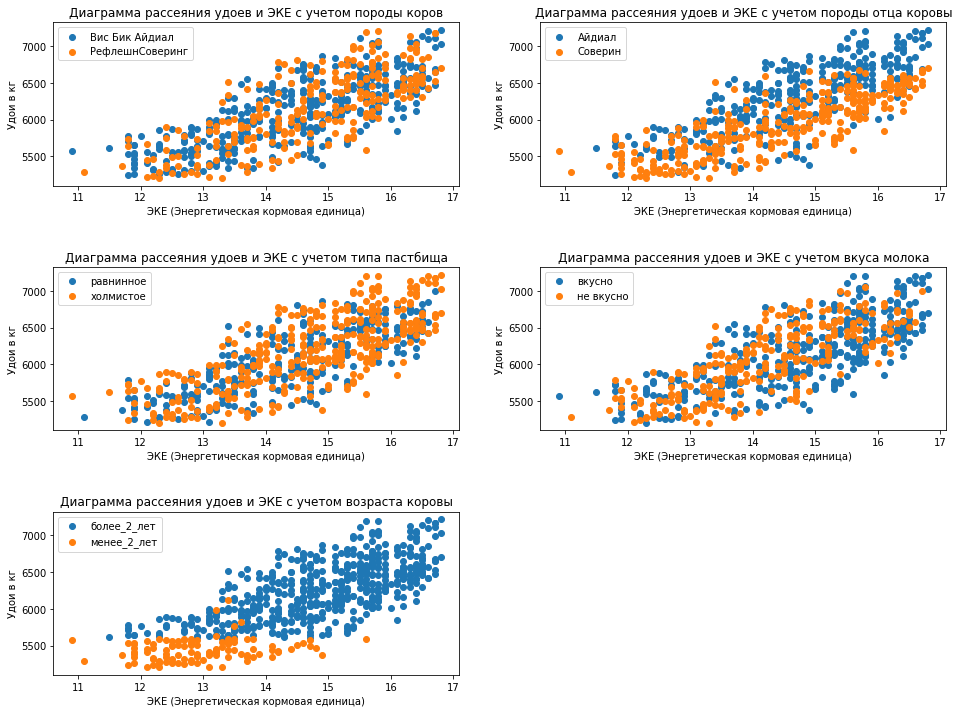

In [41]:
#выведем диаграмму рассения удоев и питательности корма коровы с учетом категориальных признаков
def scatter(z,title):
    groups = ferma.groupby(z)
    for name, group in groups:
        plt.scatter(group['efu'], group['yield'], marker='o',label=name)
        plt.title('Диаграмма рассеяния удоев и ЭКЕ с учетом ' + title)
        plt.ylabel('Удои в кг')
        plt.xlabel('ЭКЕ (Энергетическая кормовая единица)')
        plt.legend()
plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace = 0.5)
plt.subplot(3, 2, 1)
scatter('kind','породы коров')
plt.subplot(3, 2, 2)
scatter('kind_of_dad','породы отца коровы')
plt.subplot(3, 2, 3)
scatter('pasture','типа пастбища')
plt.subplot(3, 2, 4)
scatter('taste','вкуса молока')
plt.subplot(3, 2, 5)
scatter('age','возраста коровы')

Согласно диаграмме рассения удоев и питательности корма прослеживается существенная прямая связь между признаками (максимальные значения коэф-то Фи и Пирсона среди числовых значений), при этом она больше соответствует нелинейной -степенной или экспоненциальной. Рассмотрим в разрезе категориальных:
 - с учетом породы коров: не прослеживается существенного отличия,
 - с учетом породы отца коров: начиная от значения ЭКЕ свыше 12.4 более высоким значениям удоев соответствует порода Айдал,
 - с учетом типа пастбища: начиная примерно с ЭКЕ свыше 15, более высоким значениям удоев соответствует холмистый тип пастбища,
 - вкус молока: до отметки ниже 7000 кг удоев не прослеживается существенного отличия во вкусе, при этом максимальным значениям удоев при ЭКЕ свыше 15.5 соответствует "вкусное" молоко,
 - возраст коров: при любом значении ЭКЕ для получения удоев свыше примерно 5600 кг возраст коров должен быть свыше 2-х лет, за небольшим исключением (попало 4 значения), т.е. для возраста коров менее 2-х лет корреляция с удоями и ЭКЕ практически отсутствует - удои не будут выше 5600 кг

### 4.2.3. Диаграммы рассеяния  для признака Удой, кг и СПО

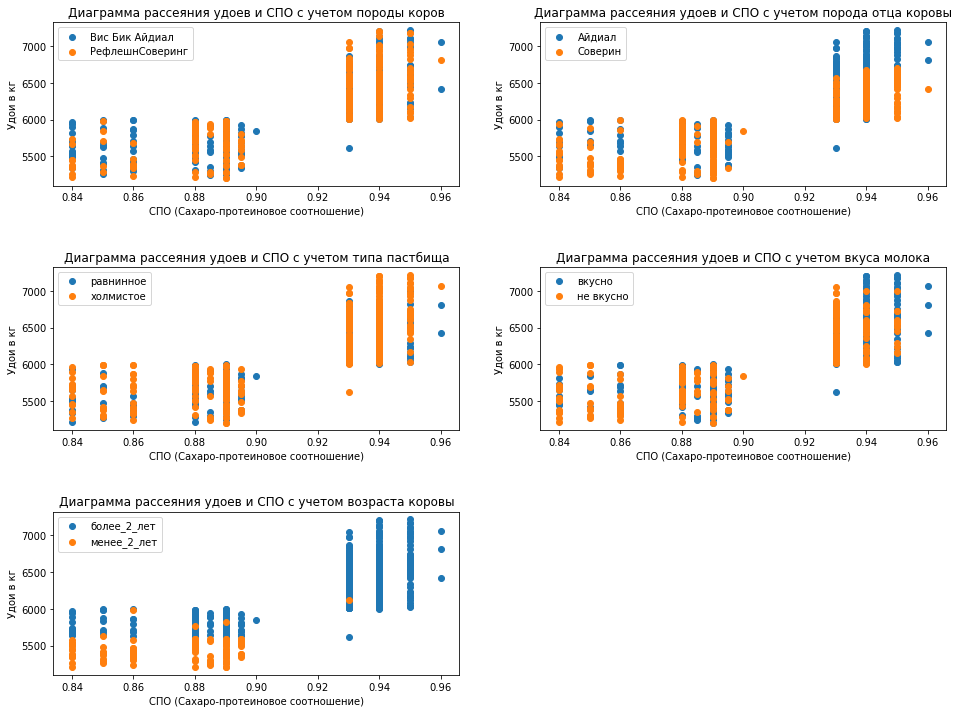

In [42]:
#выведем диаграмму рассения удоев и сахарно-протеинового соотношения с учетом категориальных признаков
def scatter(z,title):
    groups = ferma.groupby(z)
    for name, group in groups:
        plt.scatter(group['spr'], group['yield'], marker='o',label=name)
        plt.title('Диаграмма рассеяния удоев и СПО с учетом ' + title)
        plt.ylabel('Удои в кг')
        plt.xlabel('СПО (Сахаро-протеиновое соотношение)')
        plt.legend()
plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace = 0.5)
plt.subplot(3, 2, 1)
scatter('kind','породы коров')
plt.subplot(3, 2, 2)
scatter('kind_of_dad','порода отца коровы')
plt.subplot(3, 2, 3)
scatter('pasture','типа пастбища')
plt.subplot(3, 2, 4)
scatter('taste','вкуса молока')
plt.subplot(3, 2, 5)
scatter('age','возраста коровы')

Согласно диаграмме рассения удоев и СПО прослеживается прямая связь между признаками (максимальные значения коэф-то Фи и Пирсона среди числовых значений),но только при СПО равном или большем 0.93 - видим существенный скачок в удоях, которые практически не опускаются ниже 6000 кг. Рассмотрим в разрезе категориальных:
 - с учетом породы коров: не прослеживается существенного отличия,
 - с учетом породы отца коров: начиная значения СПО свыше 0.93, более высоким значениям удоев соответствует порода Айдал,
 - с учетом типа пастбища: не прослеживается существенного отличия,
 - вкус молока: до отметки ниже 6800 кг удоев не прослеживается существенного отличия во вкусе, при этом максимальным значениям удоев при СПО от 0.94 соответствует "вкусное" молоко,
 - возраст коров: при любом значении СПО для получения удоев свыше примерно 5600 кг возраст коров должен быть свыше 2-х лет, за небольшим исключением (попало 4 значения)

### 4.2.4. Диаграммы рассеяния  для признака Удой, кг и % жирности молока

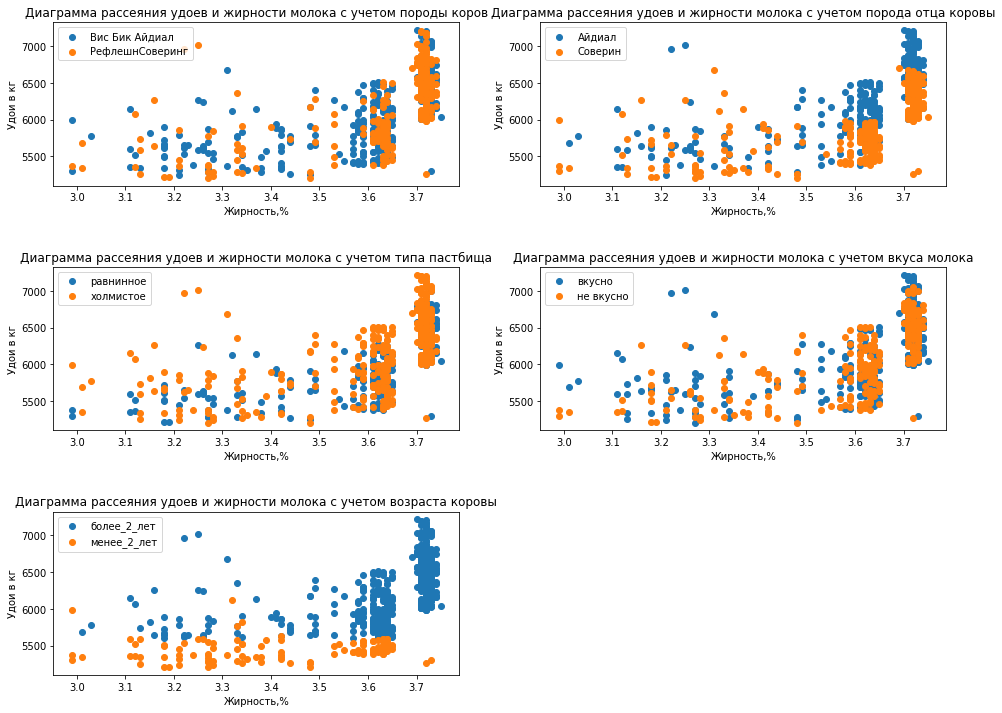

In [43]:
#выведем диаграмму рассения удоев и жирности молока с учетом категориальных признаков
def scatter(z,title):
    groups = ferma.groupby(z)
    for name, group in groups:
        plt.scatter(group['fat_percent'], group['yield'], marker='o',label=name)
        plt.title('Диаграмма рассеяния удоев и жирности молока с учетом ' + title)
        plt.ylabel('Удои в кг')
        plt.xlabel('Жирность,%')
        plt.legend()
plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace = 0.5)
plt.subplot(3, 2, 1)
scatter('kind','породы коров')
plt.subplot(3, 2, 2)
scatter('kind_of_dad','порода отца коровы')
plt.subplot(3, 2, 3)
scatter('pasture','типа пастбища')
plt.subplot(3, 2, 4)
scatter('taste','вкуса молока')
plt.subplot(3, 2, 5)
scatter('age','возраста коровы')

Согласно диаграмме рассения удоев и жирности молока линейная прямая зависимость прослеживается только при жирности молока около 3.7 и выше. Рассмотрим в разрезе категориальных:
 - с учетом породы коров: не прослеживается существенного отличия,
 - с учетом породы отца коров: начиная значения жирности свыше 3.57%, более высоким значениям удоев соответствует порода Айдал,
 - с учетом типа пастбища: для холмистого пастбища в целом более высокие значения удоев, независимо от жирности
 - вкус молока: до отметки ниже 7000 кг удоев не прослеживается существенного отличия во вкусе, при этом максимальным значениям удоев при жирности свыше 3.7 соответствует "вкусное" молоко,
 - возраст коров: при любом значении жирности для получения удоев свыше примерно 5600 кг возраст коров должен быть свыше 2-х лет, за небольшим исключением (попало 4 значения),т.е. линейная корреляция удоев и жирности при возрасте менее 2-х лет отсутствует

### 4.2.5. Диаграммы рассеяния  для признака Удой, кг и % белка в молоке

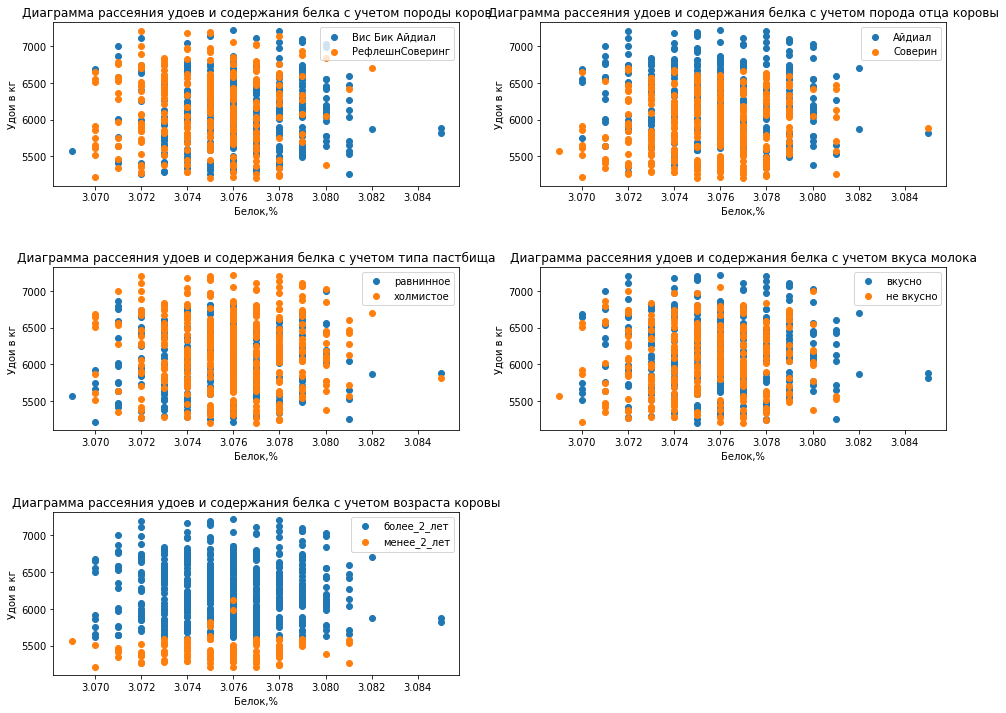

In [44]:
#выведем диаграмму рассения удоев и содержания белков в молоке с учетом категориальных признаков
def scatter(z,title):
    groups = ferma.groupby(z)
    for name, group in groups:
        plt.scatter(group['protein_percent'], group['yield'], marker='o',label=name)
        plt.title('Диаграмма рассеяния удоев и содержания белка с учетом ' + title)
        plt.ylabel('Удои в кг')
        plt.xlabel('Белок,%')
        plt.legend()
plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace = 0.5)
plt.subplot(3, 2, 1)
scatter('kind','породы коров')
plt.subplot(3, 2, 2)
scatter('kind_of_dad','порода отца коровы')
plt.subplot(3, 2, 3)
scatter('pasture','типа пастбища')
plt.subplot(3, 2, 4)
scatter('taste','вкуса молока')
plt.subplot(3, 2, 5)
scatter('age','возраста коровы')

Согласно диаграмме рассения удоев и процента белка в молоке линейная прямая зависимость не  прослеживается, как и было подтверждено коэф-ми корреляции пунктом выше. Рассмотрим в разрезе категориальных:
 - с учетом породы коров:при проценте белка в молоке от 3.079 и выше преобладает порода ВисБик Айдал,
 - с учетом породы отца коров: независимо от процента белка, значения свыше 6700 кг удоя соответствуют породе Айдал,
 - с учетом типа пастбища: для холмистого пастбища в целом более высокие значения удоев, независимо от жирности
 - вкус молока:независимо от содержания белка, при удоях свыше 7000 кг будет "вкусное" молоко,
 - возраст коров: аналогично всем предыдущим показателям, независимо от содержания белка, при возрасте менее 2-х лет удои не будут выше 5600 кг.

## 4.3. Выводы о взаимосвязи признаков


1) Тип взаимосвязи между целевым (удои) и входными признаками: 
 - присутствует как линейная прямая взаимосвязь ( варьируется от слабой до высокой), что подтверждается коэф-ми коррелиции Пирсона и Фи, так и прямая нелинейная (что подтверждается диаграммой рассеяния) - это например, связь удоев с ЭКЕ и СПО, а также отсутствие корреляции - с процентом белка в молоке. 

2) Поскольку есть нелинейная связь между целевым признаком (удои) и количественными ЭКЕ и СПО, то возможно потребуется ввести 2 дополнительных признака:
 - СПО: связь с удоями прослеживается только при СПО равном или большем 0.93 (видим существенный скачок в удоях, которые практически не опускаются ниже 6000 кг), поэтому стоит создать дополнительный биномиальный признак с указанием либо СПО до 0.93, либо свыше 0.93,
 - ЭКЕ: график похож на степенную функцию(предположим, что квадратичную),
 - процент жирности молока:связь по большей части прослеживается при жирности около и свыше 3.7% - практически все удои становятся выше 6000 кг

3) Также выявлены следующие закономерности:
 - с учетом породы коров:взаимосвязь практически не прослеживается, за исключением того, что при проценте белка в молоке от 3.079 и выше преобладает порода ВисБик Айдал,
 - с учетом породы отца коров: практически при любых значениях сырого протеина, начиная от значения ЭКЕ свыше 12.4, начиная значения СПО свыше 0.93, начиная значения жирности свыше 3.57% и независимо от процента белка, наибольшие значения удоя соответствуют породе Айдал,
 - с учетом типа пастбища: начиная примерно с 1770 граммов сырого протеина,начиная примерно с ЭКЕ свыше 15,незавимисо от жирности для холмистого пастбища в целом соответствуют более высокие значения удоев,
 - вкус молока: до отметки ниже 7000 кг удоев не прослеживается существенного отличия во вкусе, при этом максимальным значениям удоев при сыром протеине в размере от 1900 грамм,при ЭКЕ свыше 15.5,при СПО от 0.94, при жирности свыше 3.7 независимо от содержания белка - молоко будет "вкусным",
 - возраст коров: при любых количественных показателях, для получения удоев свыше примерно 5600 кг возраст коров должен быть свыше 2-х лет, за небольшим исключением (попало 4 значения) 

4) Наблюдается мультиколлинеарность  между признаками возраст, ЭКЕ, СПО и содержанием жира в молоке (наибольшие коэф-ты корреляции среди количественных), при этом за исключением возраста, коэф-ты корреляции не превышают порог в 0.9, поэтому исключать данные мультиколлинеарные признаки при обучении моделей не будем

# 5. Обучение модели линейной регрессии

## 5.1. Первая модель линейной регрессии 

Целевой признак - Удой, кг.

Отберем признаки, которые подходят для модели линейной регрессии:
 - необходимо учитывать, что прогноз будет считаться по данным, которые есть в данных от Экофермы, которые не подразумевают наличие данных по вкусу молока - поэтому данный входной признак исключим,
 - показатели возраст,ЭКЕ, СПО и содержание жира являются мультиколлинеарными, но значение признаков не превышает порог 0.9, поэтому не будем исключать какие-то из них,
 - удалим данные с id коров - это не целевой признак, а идентификатор,
 - стоит отметить, что слабая корреляция прослеживается с категориальными данными порода коровы (коэф-т Фи 0.16), тип пастбища (0.28): зависимость удоев с данными признаками выявлена для породы коровы - при проценте белка в молоке от 3.079 и выше, для пастбища начиная примерно с 1770 граммов сырого протеина,начиная примерно с ЭКЕ свыше 15,незавимисо от жирности для холмистого пастбища в целом соответствуют более высокие значения удоев. Учитывая как линейную, так и нелинейную составляющую связи (совокупное влияение ряда признаков с учетом данных категориальных), оставим данные признаки
 - признак процент белка:  корреляция с этим признаком практически отсутствует(значение коэф-та Фи 0.06), поэтому проверим модель с данным признаком и без

### 5.1.1. Первая модель линейной регрессии (без признака "% белка")

В 1-й версии не возьмем признак процент белка.

Сохраним признаки, далее разобьем данные на тренировочную и тестовую выборки.
Кодируем категориальные признаки с помощью OneHotEncoder.
Масштабируем количественные признаки с помощью StandardScaler.


In [45]:
#сохранение признаков 
y = ferma['yield']
X = ferma.drop((['id','yield','taste','protein_percent']), axis=1)

In [46]:
# создание константы RANDOM_STATE
RANDOM_STATE = 42
# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

In [47]:
#зададим названия категориальных и количественных признаков
categor = ['kind','pasture','kind_of_dad','age']
numeric = ['efu','raw_protein','spr','fat_percent']

# определим метод масштабирования как стандартизацию
scaler = StandardScaler()

# обучим и трансформируем количественные признаки из тренировочной выборки
X_train_scaled = scaler.fit_transform(X_train[numeric])

# выполним преобразование количественных признаков в тестовой выборке
X_test_scaled = scaler.transform(X_test[numeric])

# выбор метода кодирования, его инициализация
encoder = OneHotEncoder(drop='first', sparse=False)

# обучим и трансформируем категориальные признаки из тренировочной выборки одной командой
X_train_ohe = encoder.fit_transform(X_train[categor])

# выполним преобразование категориальных признаков в тестовой выборке
X_test_ohe = encoder.transform(X_test[categor])

# получим от кодировщика список новых столбцов и сохраним в новой переменной 
encoder_col_names = encoder.get_feature_names()

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
# для данных OHE названия столбцов укажем из переменной encoder_col_names

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

# выведим пять первых строк из тренировочного датафрейма
X_train.head()

,x0_РефлешнСоверинг,x1_холмистое,x2_Соверин,x3_менее_2_лет,efu,raw_protein,spr,fat_percent
0,0.00,0.00,0.00,0.00,0.02,0.25,0.81,0.20
1,0.00,0.00,0.00,0.00,0.10,-1.39,-1.07,-2.62
2,0.00,1.00,0.00,0.00,0.02,1.12,0.50,0.08
3,0.00,0.00,0.00,0.00,-1.17,0.86,-0.76,0.20
4,1.00,1.00,0.00,0.00,0.57,-0.67,0.50,0.57


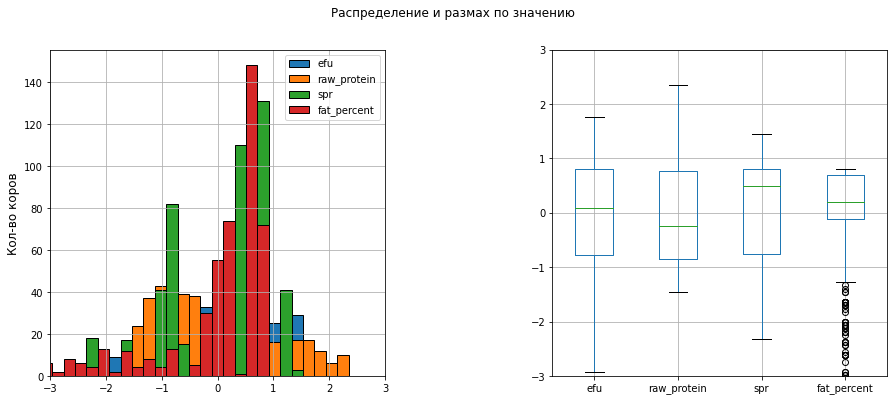

In [48]:
# построим графики по количественным признакам тренировочного датасета:
# гистограмму частотности распределения и ящик с усами.
hist_box(X_train,numeric, '',(-3,3))

Значения лежит в промежутке от -3 до 2.4, есть заметные выбросы по значению жирность молока. Очень много одинаковых значений СПО и процента жирности лежат на одном интервале 

Обучим модель линейной регрессии на подготовленных данных.

In [49]:
# инициализируем модель линейной регрессии
model_lr1  = LinearRegression()

# обучим модель на тренировочных данных
model_lr1 = model_lr1.fit(X_train,y_train)

Оценим качество модели на тестовой выборке: 
 - рассчитаем R², 
 - проанализируем остатки с помощью графиков.

In [50]:
# получим предсказания модели на тестовых данных 
# сохраним результат в переменную predictions
predictions_1 = model_lr1.predict(X_test)

#посчитаем коэф-т детерминации
r2_1 = r2_score(y_test,predictions_1) 

f'R2 LinearRegression = {r2_1:,.3f}'

'R2 LinearRegression = 0.820'

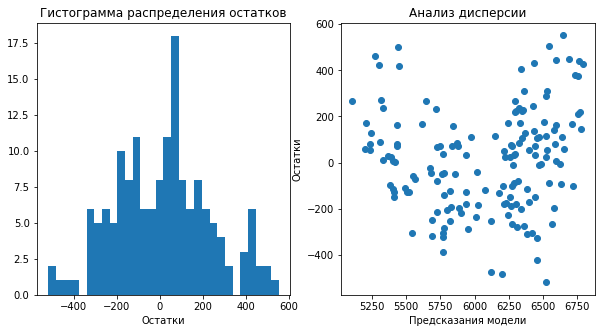

In [51]:
# рассчитаем остатки
residuals_1 = y_test - predictions_1

# построим графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals_1,bins=30)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions_1,y=residuals_1)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Вывод по обучению 1-й модели:
 - значение коэф-та детерминации R2 ниже приемлемого уровня  0.82: 82% предсказаний модели ближе к истине, чем среднее значение целевого признака.
 - гистограмма распределения остатков в целом является симметричным нормальным, при этом диаграмма рассеивания приняла вид, похожий и на "дугу", что говорит о нелинейности остатков.Для устранения нелинейности необходимо или  добавить в модель дополнительные неучтенные признаки ( например, данные об отцах коров), или трансформировать данные, чтобы изменить взаимосвязь входных признаков с целевым(например, СПО и ЭКЕ имеют нелинейных характер связи с удоями, эти признаки стоит изменить, чтобы привести связь с линейной).
 

### 5.1.2. Первая модель линейной регрессии (с признаком "% белка")

Добавим входной признак процент белка и посчитаем обучим модель с их учетом

In [52]:
#сохранение признаков 
y = ferma['yield']
X = ferma.drop((['id','yield','taste']), axis=1)

In [53]:
# создание константы RANDOM_STATE
RANDOM_STATE = 42
# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

In [54]:
#зададим названия категориальных и количественных признаков
categor = ['kind','pasture','kind_of_dad','age']
numeric = ['efu','raw_protein','spr','fat_percent','protein_percent']

# определим метод масштабирования как стандартизацию
scaler = StandardScaler()

# обучим и трансформируем количественные признаки из тренировочной выборки
X_train_scaled = scaler.fit_transform(X_train[numeric])

# выполним преобразование количественных признаков в тестовой выборке
X_test_scaled = scaler.transform(X_test[numeric])

# выбор метода кодирования, его инициализация
encoder = OneHotEncoder(drop='first', sparse=False)

# обучим и трансформируем категориальные признаки из тренировочной выборки одной командой
X_train_ohe = encoder.fit_transform(X_train[categor])

# выполним преобразование категориальных признаков в тестовой выборке
X_test_ohe = encoder.transform(X_test[categor])

# получим от кодировщика список новых столбцов и сохраним в новой переменной 
encoder_col_names = encoder.get_feature_names()

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
# для данных OHE названия столбцов укажем из переменной encoder_col_names

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

# выведим пять первых строк из тренировочного датафрейма
X_train.head()

,x0_РефлешнСоверинг,x1_холмистое,x2_Соверин,x3_менее_2_лет,efu,raw_protein,spr,fat_percent,protein_percent
0,0.00,0.00,0.00,0.00,0.02,0.25,0.81,0.20,1.67
1,0.00,0.00,0.00,0.00,0.10,-1.39,-1.07,-2.62,1.28
2,0.00,1.00,0.00,0.00,0.02,1.12,0.50,0.08,0.52
3,0.00,0.00,0.00,0.00,-1.17,0.86,-0.76,0.20,0.13
4,1.00,1.00,0.00,0.00,0.57,-0.67,0.50,0.57,-2.16


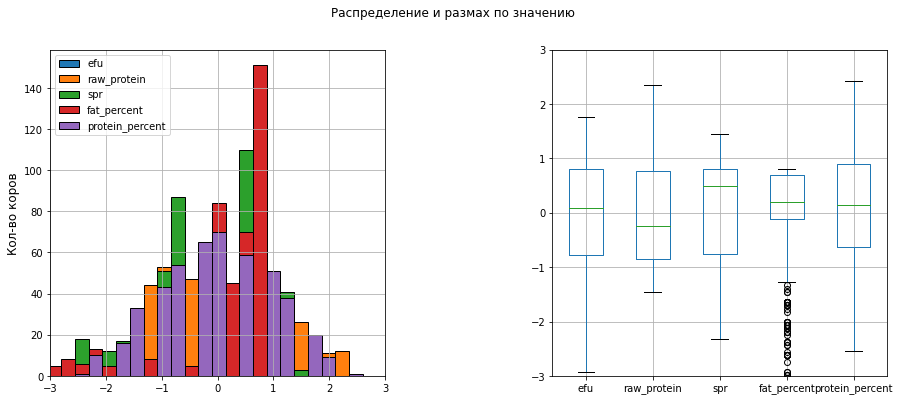

In [55]:
# построим графики по количественным признакам тренировочного датасета:
# гистограмму частотности распределения и ящик с усами.
hist_box(X_train,numeric, '',(-3,3))

После стандартизации количественные значения стали лежать в интервале от -3 до 2.6. Исходя из размаха значений процента белка после стандартизации стоит отметить, что значения показателя лежат симметрично относительно медианы

Обучим модель на тренировочных данных

In [56]:
# инициализируем модель линейной регрессии
model_lr1  = LinearRegression()

# обучим модель на тренировочных данных
model_lr1 = model_lr1.fit(X_train,y_train)

Оценим качество модели на тестовой выборке: 
 - рассчитаем R², 
 - проанализируем остатки с помощью графиков.

In [57]:
# получим предсказания модели на тестовых данных 
# сохраним результат в переменную predictions
predictions_1 = model_lr1.predict(X_test)

#посчитаем коэф-т детерминации 
r2_1 = r2_score(y_test,predictions_1) 

f'R2 LinearRegression = {r2_1:,.3f}'

'R2 LinearRegression = 0.827'

R2 с учетом процента белка чуть выше, чем без данного показателя

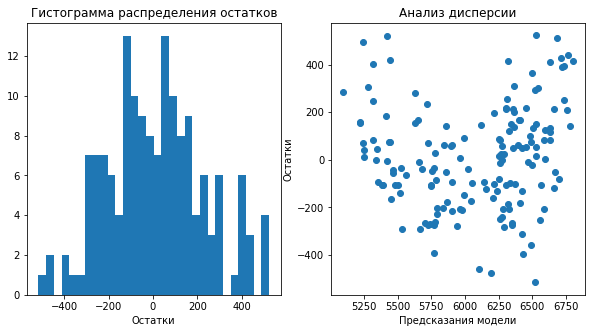

In [58]:
# рассчитаем остатки
residuals_1 = y_test - predictions_1

# построим графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals_1,bins=30)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions_1,y=residuals_1)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Картина по распределению остатков после включения данных о проценте белка практически не изменилась, при этом R2 с учетом процента белка немного выше, чем у модели без данного признака: учитывая это, а также, что данный признак все-таки есть в данных Экофермы, то стоит его учитывать в модели прогноза удоев 

## 5.2. Вторая модель линейной регрессии

Ранее мы уже выявили, что некоторые входные признаки связаны с целевым нелинейно. Трансформируем данные признаки для приведения к линейной связи:
 - СПО: связь с удоями прослеживается только при СПО равном или большем 0.93 (видим существенный скачок в удоях, которые практически не опускаются ниже 6000 кг). Создадим дополнительный биномиальный признак с указанием СПО до 0.92 и свыше (раздел по диаграмме рассеяния, при этом зависимые значения могут быть чуть меньше 0,93 и не попасть) 
 - ЭКЕ: график похож на степенную функцию 2-го порядка - возведем показатель ЭКЕ в квадрат

In [59]:
#сохранение признаков с учетом изменения СПО и ЭКЕ
y = ferma['yield']
X = ferma.drop((['id','yield','taste']), axis=1)
X['spr'] = X['spr'].apply(lambda x: 'spr_yes' if x>0.92 else 'spr_no')
X['efu'] = X['efu']**2
X.head()

,efu,raw_protein,spr,kind,pasture,kind_of_dad,fat_percent,protein_percent,age
0,201.64,1743,spr_no,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.08,более_2_лет
1,163.84,2138,spr_no,Вис Бик Айдиал,равнинное,Соверин,3.54,3.08,менее_2_лет
2,196.00,1854,spr_no,РефлешнСоверинг,холмистое,Соверин,3.59,3.07,более_2_лет
3,153.76,2012,spr_no,РефлешнСоверинг,холмистое,Айдиал,3.40,3.08,более_2_лет
4,163.84,1675,spr_no,Вис Бик Айдиал,равнинное,Соверин,3.73,3.07,менее_2_лет


In [60]:
# создание константы RANDOM_STATE
RANDOM_STATE = 42
# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

In [61]:
#зададим названия категориальных и количественных признаков
categor = ['kind','pasture','kind_of_dad','age','spr']
numeric = ['efu','raw_protein','fat_percent','protein_percent']

# определим метод масштабирования как стандартизацию
scaler = StandardScaler()

# обучим и трансформируем количественные признаки из тренировочной выборки
X_train_scaled = scaler.fit_transform(X_train[numeric])

# выполним преобразование количественных признаков в тестовой выборке
X_test_scaled = scaler.transform(X_test[numeric])

# выбор метода кодирования, его инициализация
encoder = OneHotEncoder(drop='first', sparse=False)

# обучим и трансформируем категориальные признаки из тренировочной выборки одной командой
X_train_ohe = encoder.fit_transform(X_train[categor])

# выполним преобразование категориальных признаков в тестовой выборке
X_test_ohe = encoder.transform(X_test[categor])

# получим от кодировщика список новых столбцов и сохраним в новой переменной 
encoder_col_names = encoder.get_feature_names()

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
# для данных OHE названия столбцов укажем из переменной encoder_col_names

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

# выведим пять первых строк из тренировочного датафрейма
X_train.head()

,x0_РефлешнСоверинг,x1_холмистое,x2_Соверин,x3_менее_2_лет,x4_spr_yes,efu,raw_protein,fat_percent,protein_percent
0,0.00,0.00,0.00,0.00,1.00,-0.03,0.25,0.20,1.67
1,0.00,0.00,0.00,0.00,0.00,0.05,-1.39,-2.62,1.28
2,0.00,1.00,0.00,0.00,1.00,-0.03,1.12,0.08,0.52
3,0.00,0.00,0.00,0.00,0.00,-1.17,0.86,0.20,0.13
4,1.00,1.00,0.00,0.00,1.00,0.55,-0.67,0.57,-2.16


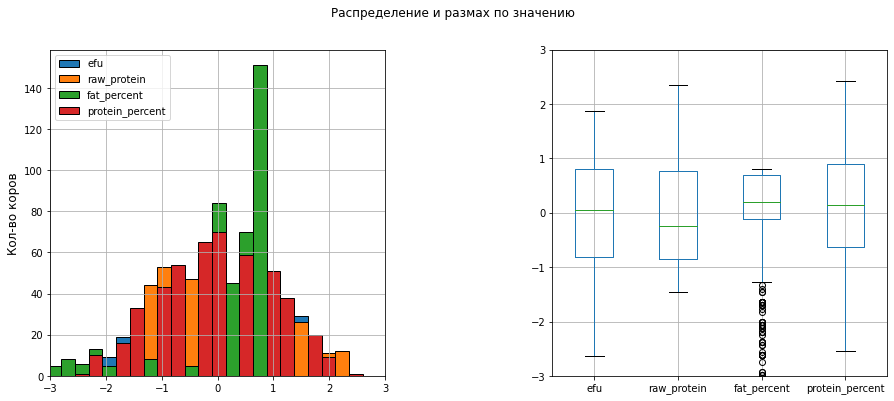

In [62]:
# построим графики по количественным признакам тренировочного датасета:
# гистограмму частотности распределения и ящик с усами.
hist_box(X_train,numeric, '',(-3,3))

Значения лежит в промежутке от -3 до 2.6, снова есть заметные выбросы по значению жирность молока. 

Обучим модель линейной регрессии на подготовленных данных.

In [63]:
# инициализируем модель линейной регрессии
model_lr2  = LinearRegression()

# обучим модель на тренировочных данных
model_lr2 = model_lr2.fit(X_train,y_train)

Оценим качество модели на тестовой выборке: 
 - рассчитаем R², 
 - проанализируем остатки с помощью графиков.

In [64]:
# получим предсказания модели на тестовых данных 
# сохраним результат в переменную predictions
predictions_2 = model_lr2.predict(X_test)

#посчитаем коэф-т детерминации 
r2_2 = r2_score(y_test,predictions_2) 

f'R2 LinearRegression = {r2_2:,.3f}'

'R2 LinearRegression = 0.850'

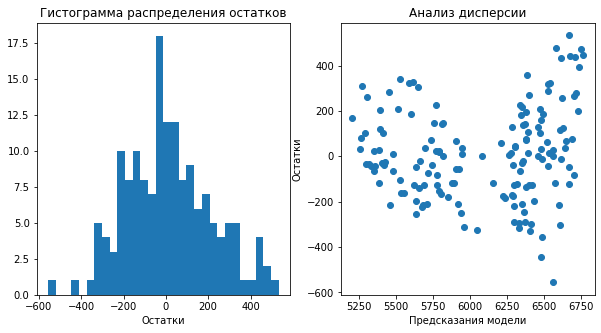

In [65]:
# рассчитаем остатки
residuals_2 = y_test - predictions_2

# построим графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals_2,bins=30)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions_2,y=residuals_2)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()


Вывод по обучению 2-й модели:
 - значение коэф-та детерминации R2 стало приемлемым 0.85: 85% предсказаний модели ближе к истине, чем среднее значение целевого признака.
 - гистограмма распределния остатков в целом является симметричным нормальным, при этом диаграмма рассеивания  похожа на "рупор", что говорит о нелинейности остатков. Мы уже трансформировали 2 признака для устранения нелинейности связи, в следующей модели добавим дополнительный признак - имена отцов коров.


## 5.3. Третья модель линейной регрессии

 Добавим признак Имя Папы из файла dad

In [66]:
#соединим таблицы с данными по ферме и именами отцов коров
ferma_m = ferma.merge(dad,on='id')
#выведем новую таблицу
ferma_m.head()

,id,yield,efu,raw_protein,spr,kind,pasture,kind_of_dad,fat_percent,protein_percent,taste,age,dad_name
0,1,5863,14.20,1743,0.89,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.08,вкусно,более_2_лет,Буйный
1,2,5529,12.80,2138,0.89,Вис Бик Айдиал,равнинное,Соверин,3.54,3.08,вкусно,менее_2_лет,Соловчик
2,3,5810,14.00,1854,0.89,РефлешнСоверинг,холмистое,Соверин,3.59,3.07,не вкусно,более_2_лет,Барин
3,4,5895,12.40,2012,0.89,РефлешнСоверинг,холмистое,Айдиал,3.40,3.08,не вкусно,более_2_лет,Буйный
4,5,5302,12.80,1675,0.89,Вис Бик Айдиал,равнинное,Соверин,3.73,3.07,вкусно,менее_2_лет,Барин


In [67]:
#сохранение признаков с учетом изменения СПО и ЭКЕ
y = ferma_m['yield']
X = ferma_m.drop((['id','yield','taste']), axis=1)
X['spr'] = X['spr'].apply(lambda x: 'spr_yes' if x>0.92 else 'spr_no')
X['efu'] = X['efu']**2

X.head()

,efu,raw_protein,spr,kind,pasture,kind_of_dad,fat_percent,protein_percent,age,dad_name
0,201.64,1743,spr_no,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.08,более_2_лет,Буйный
1,163.84,2138,spr_no,Вис Бик Айдиал,равнинное,Соверин,3.54,3.08,менее_2_лет,Соловчик
2,196.00,1854,spr_no,РефлешнСоверинг,холмистое,Соверин,3.59,3.07,более_2_лет,Барин
3,153.76,2012,spr_no,РефлешнСоверинг,холмистое,Айдиал,3.40,3.08,более_2_лет,Буйный
4,163.84,1675,spr_no,Вис Бик Айдиал,равнинное,Соверин,3.73,3.07,менее_2_лет,Барин


In [68]:
# создание константы RANDOM_STATE
RANDOM_STATE = 42
# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

In [69]:
#зададим названия категориальных и количественных признаков
categor = ['kind','pasture','kind_of_dad','age','spr','dad_name']
numeric = ['efu','raw_protein','fat_percent','protein_percent']

# определим метод масштабирования как стандартизацию
scaler = StandardScaler()

# обучим и трансформируем количественные признаки из тренировочной выборки
X_train_scaled = scaler.fit_transform(X_train[numeric])

# выполним преобразование количественных признаков в тестовой выборке
X_test_scaled = scaler.transform(X_test[numeric])

# выбор метода кодирования, его инициализация
encoder = OneHotEncoder(drop='first', sparse=False)

# обучим и трансформируем категориальные признаки из тренировочной выборки одной командой
X_train_ohe = encoder.fit_transform(X_train[categor])

# выполним преобразование категориальных признаков в тестовой выборке
X_test_ohe = encoder.transform(X_test[categor])

# получим от кодировщика список новых столбцов и сохраним в новой переменной 
encoder_col_names = encoder.get_feature_names()

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
# для данных OHE названия столбцов укажем из переменной encoder_col_names

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

# выведим пять первых строк из тренировочного датафрейма
X_train.head()

,x0_РефлешнСоверинг,x1_холмистое,x2_Соверин,x3_менее_2_лет,x4_spr_yes,x5_Буйный,x5_Геркулес,x5_Соловчик,efu,raw_protein,fat_percent,protein_percent
0,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,-0.03,0.25,0.20,1.67
1,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.05,-1.39,-2.62,1.28
2,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,-0.03,1.12,0.08,0.52
3,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,-1.17,0.86,0.20,0.13
4,1.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.55,-0.67,0.57,-2.16


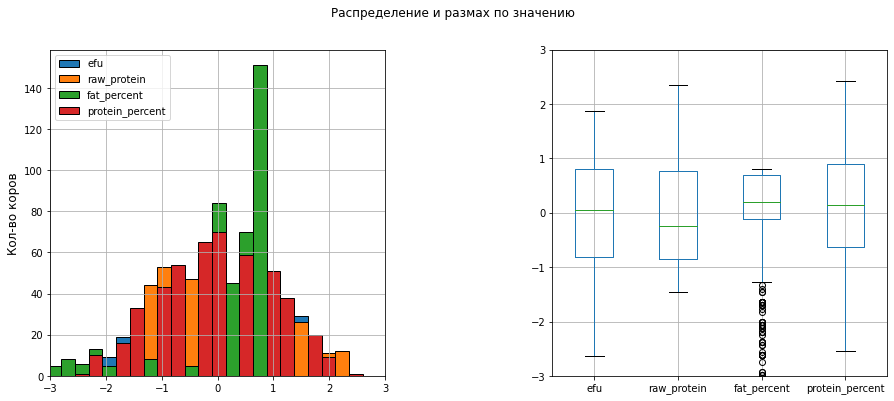

In [70]:
# построим графики по количественным признакам тренировочного датасета:
# гистограмму частотности распределения и ящик с усами.
hist_box(X_train,numeric, '',(-3,3))

Количественные не меняли, поэтому без изменений

Далее обучим модель, выведем R2 и графики с остатками 

In [71]:
# инициализируем модель линейной регрессии
model_lr3  = LinearRegression()

# обучим модель на тренировочных данных
model_lr3 = model_lr3.fit(X_train,y_train)

In [72]:
# получим предсказания модели на тестовых данных 
# сохраним результат в переменную predictions
predictions_3 = model_lr3.predict(X_test)

#посчитаем коэф-т детерминации 
r2_3 = r2_score(y_test,predictions_3) 

f'R2 LinearRegression = {r2_3:,.3f}'

'R2 LinearRegression = 0.869'

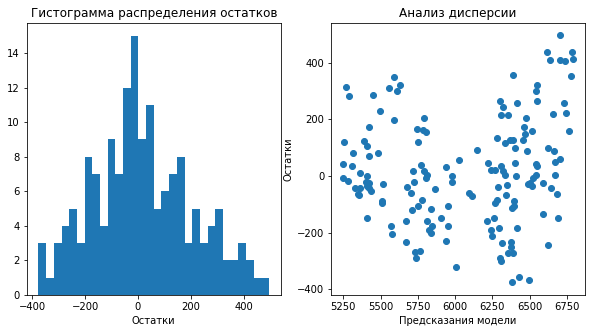

In [73]:
# рассчитаем остатки
residuals_3 = y_test - predictions_3

# построим графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals_3,bins=30)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions_3,y=residuals_3)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Вывод по обучению 3-й модели:
 - значение коэф-та детерминации R2 стало выше 0.87: 87% предсказаний модели ближе к истине, чем среднее значение целевого признака.
 - гистограмма распределния остатков по-прежнему симметрична, диаграмма рассеивания  уже больше похожа на "нормальную".

## 5.4. Четвертая модель линейной регрессии

Помимо проведенных выше трансформации 2-х количественных входных признаков и добавления нового (имени отцов коров), попробуем обучить еще одну модель, трансформировав еще один входной количественный признак - процент жирности:
 - по диаграмме рассеяния для удоев и процента жирности было выявлено, что зависимость удоев от жирности ярко проявляется при проценте жирности около 3.7% и выше. Поэтому также трансформируем данный количественный признак в биномиальный с границей около 3.67 (согласно диаграмме рассеивания это значение примерно разделяет график)

In [74]:
#сохранение признаков с учетом изменения СПО и ЭКЕ
y = ferma_m['yield']
X = ferma_m.drop((['id','yield','taste']), axis=1)
X['spr'] = X['spr'].apply(lambda x: 'spr_yes' if x>0.92 else 'spr_no')
X['efu'] = X['efu']**2
X['fat_percent'] = X['fat_percent'].apply(lambda x: 'fat_yes' if x>3.67 else 'fat_no')

X.head()

,efu,raw_protein,spr,kind,pasture,kind_of_dad,fat_percent,protein_percent,age,dad_name
0,201.64,1743,spr_no,Вис Бик Айдиал,равнинное,Айдиал,fat_no,3.08,более_2_лет,Буйный
1,163.84,2138,spr_no,Вис Бик Айдиал,равнинное,Соверин,fat_no,3.08,менее_2_лет,Соловчик
2,196.00,1854,spr_no,РефлешнСоверинг,холмистое,Соверин,fat_no,3.07,более_2_лет,Барин
3,153.76,2012,spr_no,РефлешнСоверинг,холмистое,Айдиал,fat_no,3.08,более_2_лет,Буйный
4,163.84,1675,spr_no,Вис Бик Айдиал,равнинное,Соверин,fat_yes,3.07,менее_2_лет,Барин


In [75]:
# создание константы RANDOM_STATE
RANDOM_STATE = 42
# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

In [76]:
#зададим названия категориальных и количественных признаков
categor = ['kind','pasture','kind_of_dad','age','spr','dad_name','fat_percent']
numeric = ['efu','raw_protein','protein_percent']

# определим метод масштабирования как стандартизацию
scaler = StandardScaler()

# обучим и трансформируем количественные признаки из тренировочной выборки
X_train_scaled = scaler.fit_transform(X_train[numeric])

# выполним преобразование количественных признаков в тестовой выборке
X_test_scaled = scaler.transform(X_test[numeric])

# выбор метода кодирования, его инициализация
encoder = OneHotEncoder(drop='first', sparse=False)

# обучим и трансформируем категориальные признаки из тренировочной выборки одной командой
X_train_ohe = encoder.fit_transform(X_train[categor])

# выполним преобразование категориальных признаков в тестовой выборке
X_test_ohe = encoder.transform(X_test[categor])

# получим от кодировщика список новых столбцов и сохраним в новой переменной 
encoder_col_names = encoder.get_feature_names()
# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
# для данных OHE названия столбцов укажем из переменной encoder_col_names

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

# выведим пять первых строк из тренировочного датафрейма
X_train.head()

,x0_РефлешнСоверинг,x1_холмистое,x2_Соверин,x3_менее_2_лет,x4_spr_yes,x5_Буйный,x5_Геркулес,x5_Соловчик,x6_fat_yes,efu,raw_protein,protein_percent
0,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,-0.03,0.25,1.67
1,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.05,-1.39,1.28
2,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,-0.03,1.12,0.52
3,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,-1.17,0.86,0.13
4,1.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.55,-0.67,-2.16


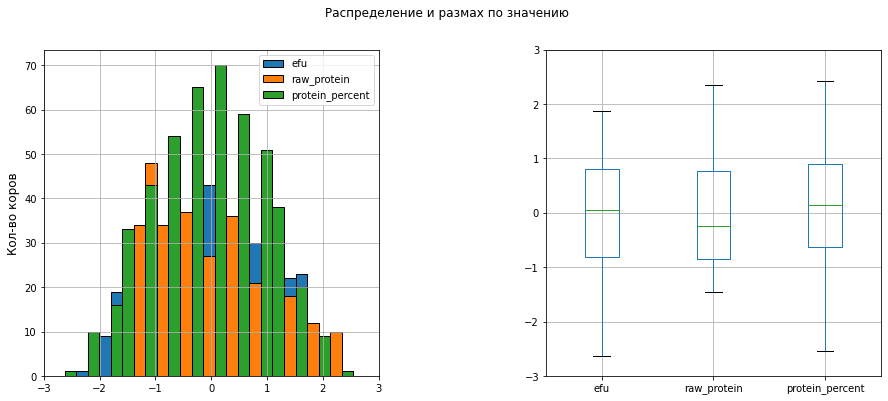

In [77]:
# построим графики по количественным признакам тренировочного датасета:
# гистограмму частотности распределения и ящик с усами.
hist_box(X_train,numeric, '',(-3,3))

Распределение количественных признаков после стандартизации является "нормальным". Один количественный входной признак изменили трансформипровали в качественный и это привело к изменению интервала стандартизации (было от -3 до 2.4, стало от -2.6 до 2.6), что видимо связано с удалением признака процент жирности, который после стандартизации имел большое кол-во выбросов.

Обучим модель, выведем R2 и проведем анализ остатков.

In [78]:
# инициализируем модель линейной регрессии
model_lr4  = LinearRegression()

# обучим модель на тренировочных данных
model_lr4 = model_lr4.fit(X_train,y_train)

In [79]:
# получим предсказания модели на тестовых данных 
# сохраним результат в переменную predictions
predictions_4 = model_lr4.predict(X_test)

#посчитаем коэф-т детерминации 
r2_4 = r2_score(y_test,predictions_4) 

f'R2 LinearRegression = {r2_4:,.3f}'

'R2 LinearRegression = 0.879'

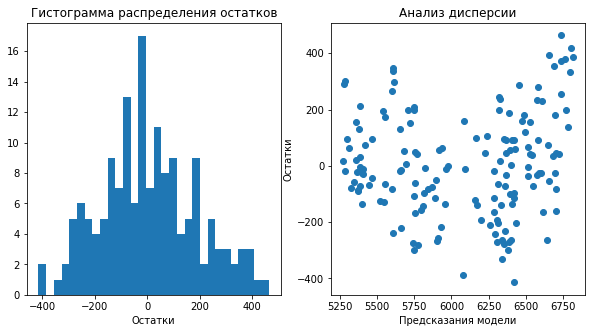

In [80]:
# рассчитаем остатки
residuals_4 = y_test - predictions_4

# построим графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals_4,bins=30)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions_4,y=residuals_4)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Вывод по обучению 4-й модели:
 - значение коэф-та детерминации R2 стало выше - 0.88: 88% предсказаний модели ближе к истине, чем среднее значение целевого признака.
 - гистограмма распределния остатков по-прежнему симметрична, диаграмма рассеивания  больше похожа на "нормальную".

## 5.5. Пятая модель линейной регрессии

Построим также модель, аналогичную 4-й, но без учета входных признаков - характеристик молока (процент жирности и процент белка) 

In [81]:
#сохранение признаков с учетом изменения СПО и ЭКЕ
y = ferma_m['yield']
X = ferma_m.drop((['id','yield','taste','fat_percent','protein_percent']), axis=1)
X['spr'] = X['spr'].apply(lambda x: 'spr_yes' if x>0.92 else 'spr_no')
X['efu'] = X['efu']**2

X.head()

,efu,raw_protein,spr,kind,pasture,kind_of_dad,age,dad_name
0,201.64,1743,spr_no,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,Буйный
1,163.84,2138,spr_no,Вис Бик Айдиал,равнинное,Соверин,менее_2_лет,Соловчик
2,196.00,1854,spr_no,РефлешнСоверинг,холмистое,Соверин,более_2_лет,Барин
3,153.76,2012,spr_no,РефлешнСоверинг,холмистое,Айдиал,более_2_лет,Буйный
4,163.84,1675,spr_no,Вис Бик Айдиал,равнинное,Соверин,менее_2_лет,Барин


In [82]:
# создание константы RANDOM_STATE
RANDOM_STATE = 42
# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

In [83]:
#зададим названия категориальных и количественных признаков
categor = ['kind','pasture','kind_of_dad','age','spr','dad_name']
numeric = ['efu','raw_protein']

# определим метод масштабирования как стандартизацию
scaler_1 = StandardScaler()

# обучим и трансформируем количественные признаки из тренировочной выборки
X_train_scaled = scaler_1.fit_transform(X_train[numeric])

# выполним преобразование количественных признаков в тестовой выборке
X_test_scaled = scaler_1.transform(X_test[numeric])

# выбор метода кодирования, его инициализация
encoder_1 = OneHotEncoder(drop='first', sparse=False)

# обучим и трансформируем категориальные признаки из тренировочной выборки одной командой
X_train_ohe = encoder_1.fit_transform(X_train[categor])

# выполним преобразование категориальных признаков в тестовой выборке
X_test_ohe = encoder_1.transform(X_test[categor])

# получим от кодировщика список новых столбцов и сохраним в новой переменной 
encoder_col_names = encoder_1.get_feature_names()
# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
# для данных OHE названия столбцов укажем из переменной encoder_col_names

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

# выведим пять первых строк из тренировочного датафрейма
X_train.head()

,x0_РефлешнСоверинг,x1_холмистое,x2_Соверин,x3_менее_2_лет,x4_spr_yes,x5_Буйный,x5_Геркулес,x5_Соловчик,efu,raw_protein
0,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,-0.03,0.25
1,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.05,-1.39
2,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,-0.03,1.12
3,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,-1.17,0.86
4,1.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.55,-0.67


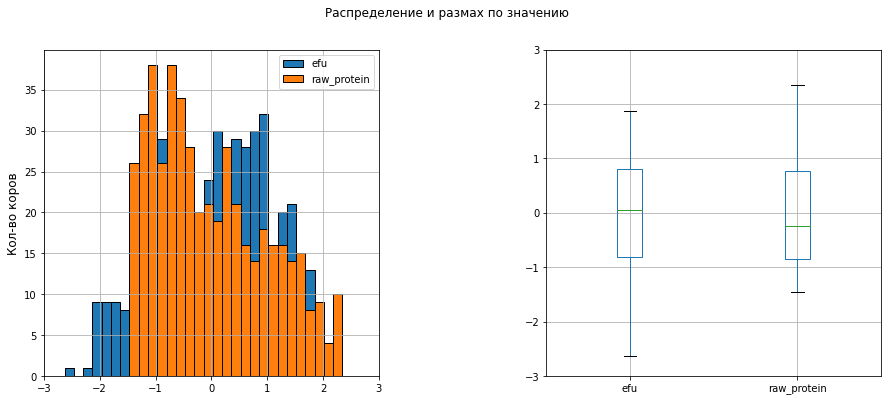

In [84]:
# построим графики по количественным признакам тренировочного датасета:
# гистограмму частотности распределения и ящик с усами.
hist_box(X_train,numeric, '',(-3,3))

Интервал после стандартизации  от -2.6 до 2.4.

Обучим модель, выведем R2 и проведем анализ остатков.

In [85]:
# инициализируем модель линейной регрессии
model_lr5  = LinearRegression()

# обучим модель на тренировочных данных
model_lr5 = model_lr5.fit(X_train,y_train)

In [86]:
# получим предсказания модели на тестовых данных 
# сохраним результат в переменную predictions
predictions_5 = model_lr5.predict(X_test)

#посчитаем коэф-т детерминации 
r2_5 = r2_score(y_test,predictions_5) 

f'R2 LinearRegression = {r2_5:,.3f}'

'R2 LinearRegression = 0.863'

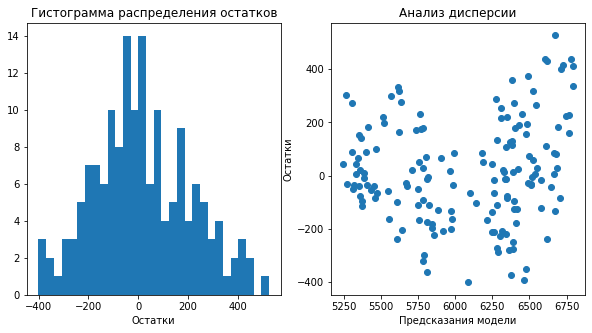

In [87]:
# рассчитаем остатки
residuals_5 = y_test - predictions_5

# построим графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals_5,bins=30)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions_5,y=residuals_5)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Вывод по обучению 5-й модели:
 - значение коэф-та детерминации R2 стало ниже - 0.86: 86% предсказаний модели ближе к истине, чем среднее значение целевого признака.
 - гистограмма распределния остатков по-прежнему симметрична, диаграмма рассеивания  больше похожа на "нормальную".

## 5.6. Сравнение качества моделей: R2 и "остатки"

Наши модели имеют следующие значение коэф-та R2  и характеристику графиков распределения и рассеивания остатков (R2 округлено до тысячных):
 - 1 модель: значение коэф-та детерминации R2 чуть ниже приемлемого уровня -  0.827, гистограмма распределения остатков в целом является симметричным нормальным, при этом диаграмма рассеивания приняла вид, похожий и на "дугу", и на "рупор", что говорит о нелинейности остатков.
 - 2 модель: значение коэф-та детерминации R2 стало выше - 0.85, гистограмма распределения остатков в целом является симметричным нормальным, при этом диаграмма рассеивания похожа на "рупор", что говорит о нелинейности остатков.
 - 3 модель: значение коэф-та детерминации R2 стало выше - 0.869, гистограмма распределения остатков по-прежнему симметрична, диаграмма рассеивания  уже больше похожа на "нормальную".
 - 4 модель: гистограмма распределения остатков по-прежнему симметрична, диаграмма рассеивания не намного отличается от 3-й модели, но значение коэф-та детерминации R2 выше, чем у 3-й модели, - 0.879. Из диаграммы рассеивания остатков видно, что после примерно 6600 кг удоев разброс остатков становится выше
 - 5 модель:гистограмма распределения остатков по-прежнему симметрична, диаграмма рассеивания не намного отличается от 3-й и 4-й модели, но значение коэф-та детерминации R2 ниже, чем у 3-й и 4-й модели, - 0.863. 
 
Сравним качества моделей также на остальных метриках 

## 5.7. Сравнение качества моделей: метрики MSE, MAE, RMSE

In [88]:
# создадим список из предсказаний каждой модели
list_to = [predictions_1,predictions_2,predictions_3,predictions_4,predictions_5]

#создадим цикл для расчета и вывода метрик
for index, item in enumerate(list_to):
    print(f'Модель {index+1}: MSE ={mean_squared_error(y_test, item):,.1f},\
    RMSE= {mean_squared_error(y_test, item, squared=False):,.1f},\
    MAE ={mean_absolute_error(y_test, item):,.1f}')   

Модель 1: MSE =47,443.2,    RMSE= 217.8,    MAE =174.8
Модель 2: MSE =41,062.5,    RMSE= 202.6,    MAE =159.2
Модель 3: MSE =35,762.8,    RMSE= 189.1,    MAE =148.6
Модель 4: MSE =33,197.8,    RMSE= 182.2,    MAE =145.6
Модель 5: MSE =37,613.2,    RMSE= 193.9,    MAE =153.5


Чем меньше значение  MSE, MAE, RMSE и больше значение R2 - тем выше качество модели. Поэтому,исходя из указанных выше метрик, а также вспоминая значение R2, - более качественной моделью является 4-я.

Исходя из исследовательского анализа, в удоях фермы отсутствуют выбросы (одно нехарактерное значение скорректировано), поэтому MAE здесь больше подходит, чем RMSE.

Прогноз для 4-й модели, исходя из посчитанных выше коэф-в:
 - прогнозное значение удоя в среднем отличается от истинного на 145.6 кг (берем MAE). Это значит, что истинное значение удоя лежит в интервале от предсказанное значение минус 145.6 кг, до предсказанное значение плюс 145.6 кг.
 
Посчитаем доверительный интервал исходя из value 5% 

In [89]:
f'Доверительный интервал от {np.quantile(predictions_4, 0.025):.1f} до {np.quantile(predictions_4, 0.975):.1f}'


'Доверительный интервал от 5296.2 до 6769.9'

Таким образом, доверительный интервал прогноза наилучшей модели лежит в интервале от 5296 до 6770 кг удоев

## 5.8. Прогноз удоя коров

С помощью лучшей модели (4-й) спрогнозируем удой коров, которых фермер хочет купить. Данные о них находятся в датасете от Экофермы
Добавим недостающие признаки ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г и СПО (Сахаро-протеиновое соотношение): возьмем  из датасета ferma_main.csv средние значения каждого из признаков и увеличим их на 5%.
Выполним подготовку данных, аналогичную той, которую делали для тренировочной выборки.
Получим прогноз удоя коров.

In [90]:
#зададим список столбцов к добавлению
new = ['efu','raw_protein','spr']
#создадим присвоим новой таблице данные Экофермы
prognoz = cow
#через цикл создадим новые столбцы из списка выше средними значениями таблицы фермы с именами отцов 
#с увеличением этих значений на 5%
for i in new:
    prognoz[i] = ferma_m[i].mean()*1.05
#выведем 5 первых строк созданной таблицы
prognoz.head()   

,kind,pasture,kind_of_dad,dad_name,current_fat_percent,current_protein_percent,age,efu,raw_protein,spr
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет,15.27,"2,019.53",0.96
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.08,менее_2_лет,15.27,"2,019.53",0.96
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.07,более_2_лет,15.27,"2,019.53",0.96
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.06,более_2_лет,15.27,"2,019.53",0.96
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.07,более_2_лет,15.27,"2,019.53",0.96


In [91]:
#добавим в таблицу столбцы с транспормированными признаками СПО,ЭКЕ
prognoz['spr'] = prognoz['spr'].apply(lambda x: 'spr_yes' if x>0.92 else 'spr_no')
prognoz['efu'] = prognoz['efu']**2
#переименуем столбцы текущая жирность/%белка
prognoz = prognoz.rename(
    columns={'current_fat_percent': 'fat_percent','current_protein_percent':'protein_percent'}
)
#добавим в таблицу столбец с транспормированным признакос процента жирности             
prognoz['fat_percent'] = prognoz['fat_percent'].apply(lambda x: 'fat_yes' if x>3.67 else 'fat_no')

prognoz.head()

,kind,pasture,kind_of_dad,dad_name,fat_percent,protein_percent,age,efu,raw_protein,spr
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,fat_no,3.08,более_2_лет,233.21,"2,019.53",spr_yes
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,fat_no,3.08,менее_2_лет,233.21,"2,019.53",spr_yes
2,РефлешнСоверинг,равнинное,Соверин,Барин,fat_no,3.07,более_2_лет,233.21,"2,019.53",spr_yes
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,fat_no,3.06,более_2_лет,233.21,"2,019.53",spr_yes
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,fat_no,3.07,более_2_лет,233.21,"2,019.53",spr_yes


In [92]:
#зададим названия категориальных и количественных признаков: 
#отдельно выделим категориальный признак по СПО, чтобы столбец с ним не удалялся(будет кодироваться только как 1) 
categor_1= ['kind','pasture','kind_of_dad','age','dad_name','fat_percent']
categor_2= ['spr']
numeric = ['efu','raw_protein','protein_percent']

#трансформируем количественные признаки
prognoz_scaled = scaler.transform(prognoz[numeric])

encoder = OneHotEncoder(drop = 'first', sparse = False)

encoder_2 = OneHotEncoder(drop = None, sparse = False)
#трансформируем категориальные признаки
prognoz_ohe_1 = encoder.fit_transform(prognoz[categor_1])
prognoz_ohe_2 = encoder_2.fit_transform(prognoz[categor_2])

# получим от кодировщика список новых столбцов и сохраним в новой переменной 
encoder_col_names_1 = encoder.get_feature_names()
encoder_col_names_2 = encoder_2.get_feature_names()

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
# для данных OHE названия столбцов укажем из переменной encoder_col_names
prognoz_ohe_1 = pd.DataFrame(prognoz_ohe_1, columns=encoder_col_names_1)
prognoz_ohe_2 = pd.DataFrame(prognoz_ohe_2, columns=encoder_col_names_2)
prognoz_scaled = pd.DataFrame(prognoz_scaled, columns=numeric)

# объединяем все преобразованные данные в датафрейм
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок
prognoz = pd.concat([prognoz_ohe_1,prognoz_ohe_2], axis=1)
prognoz = pd.concat([prognoz, prognoz_scaled], axis=1)
prognoz.head()

,x0_РефлешнСоверинг,x1_холмистое,x2_Соверин,x3_менее_2_лет,x4_Буйный,x4_Геркулес,x4_Соловчик,x5_fat_yes,x0_spr_yes,efu,raw_protein,protein_percent
0,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.53,0.54,0.13
1,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.53,0.54,2.05
2,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.53,0.54,-0.63
3,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.53,0.54,-5.61
4,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.53,0.54,-0.63


In [93]:
# получим прогноз,сохраним результат в отдельный столбец
prognoz['yeild'] = model_lr4.predict(prognoz)
prognoz['yeild']

0    6,365.69
1    6,026.63
2    6,043.75
3    6,479.23
4    6,318.38
5    6,236.04
6    6,365.69
7    6,255.44
8    6,043.75
9    6,143.57
10   6,523.83
11   6,356.60
12   6,604.70
13   5,877.75
14   6,043.75
15   6,452.52
16   6,363.55
17   6,274.71
18   6,322.22
19   6,318.38
Name: yeild, dtype: float64

Таким образом, мы получили прогноз удоя для каждой из 20 коров в файле Экофермы

# 6.Обучение модели логистической регрессии

## 6.1.Обучение модели

Корреляция вкуса молока прослеживается с удоями, ЭКЕ, сырым протеином, СПО,типом пастбища,с процентом жирности и белка, с возрастом. С породой коровы и отца коровы - корреляция отсутствует (коэф-т Фи равен 0). При этом данные удоев при обучении модели мы не учитываем, т.к. при покупке коровы их заранее не знаем (аналогично тому, как не знали вкус при прогнозировании удоев).

Т.о., входные признаки: ЭКЕ, сырой протеин, СПО,тип пастбища,процент жирности и белка, возраст.

Обучим модель

In [94]:
#сохранение признаков 
y = ferma_m['taste']
X = ferma_m.drop((['id','yield','taste','kind','kind_of_dad']), axis=1)
X.head()

,efu,raw_protein,spr,pasture,fat_percent,protein_percent,age,dad_name
0,14.20,1743,0.89,равнинное,3.58,3.08,более_2_лет,Буйный
1,12.80,2138,0.89,равнинное,3.54,3.08,менее_2_лет,Соловчик
2,14.00,1854,0.89,холмистое,3.59,3.07,более_2_лет,Барин
3,12.40,2012,0.89,холмистое,3.40,3.08,более_2_лет,Буйный
4,12.80,1675,0.89,равнинное,3.73,3.07,менее_2_лет,Барин


In [95]:
#закодируем вкус: вкусно-1,невкусно-0
y = y.apply(lambda x: 1 if x=='вкусно' else 0)

In [96]:
# создание константы RANDOM_STATE
RANDOM_STATE = 42
# разбиваем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

In [97]:
#зададим названия категориальных и количественных признаков
categor = ['pasture','age','dad_name']
numeric = ['efu','raw_protein','protein_percent','spr','fat_percent']

# определим метод масштабирования как стандартизацию
scaler = StandardScaler()

# обучим и трансформируем количественные признаки из тренировочной выборки
X_train_scaled = scaler.fit_transform(X_train[numeric])

# выполним преобразование количественных признаков в тестовой выборке
X_test_scaled = scaler.transform(X_test[numeric])

# выбор метода кодирования, его инициализация
encoder = OneHotEncoder(drop='first', sparse=False)

# обучим и трансформируем категориальные признаки из тренировочной выборки одной командой
X_train_ohe = encoder.fit_transform(X_train[categor])

# выполним преобразование категориальных признаков в тестовой выборке
X_test_ohe = encoder.transform(X_test[categor])

# получим от кодировщика список новых столбцов и сохраним в новой переменной 
encoder_col_names = encoder.get_feature_names()
# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
# для данных OHE названия столбцов укажем из переменной encoder_col_names

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

# выведем пять первых строк из тренировочного датафрейма
X_train.head()

,x0_холмистое,x1_менее_2_лет,x2_Буйный,x2_Геркулес,x2_Соловчик,efu,raw_protein,protein_percent,spr,fat_percent
0,0.00,0.00,1.00,0.00,0.00,0.02,0.25,1.67,0.81,0.20
1,0.00,0.00,1.00,0.00,0.00,0.10,-1.39,1.28,-1.07,-2.62
2,1.00,0.00,1.00,0.00,0.00,0.02,1.12,0.52,0.50,0.08
3,0.00,0.00,0.00,1.00,0.00,-1.17,0.86,0.13,-0.76,0.20
4,1.00,0.00,1.00,0.00,0.00,0.57,-0.67,-2.16,0.50,0.57


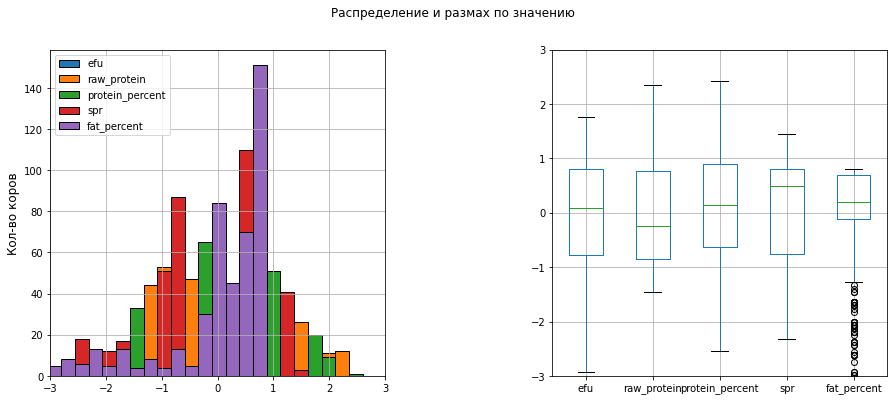

In [98]:
# построим графики по количественным признакам тренировочного датасета:
# гистограмму частотности распределения и ящик с усами.
hist_box(X_train,numeric, '',(-3,3))

Количественные признаки после стандартизации лежат в интервале от -3 до 2.6, медианы колеблятся около 0, у процента жирности присутствуют выбросы.

Обучим модель, получим предсказания

In [99]:
# создаём объект для работы с моделью
clf = LogisticRegression(random_state=RANDOM_STATE)

# обучаем модель на данных
clf = clf.fit(X_train,y_train)

In [100]:
# получим предсказания модели на тестовых данных 
# сохраним результат
y_pred = clf.predict(X_test)

Посчитаем коэф-ты для всех входных признаков

In [101]:
for feature_number, feature_name in enumerate(X_train.columns):
    weight = clf.coef_[0, feature_number]
    print(f"{feature_name:<20}: {weight:+.2f}")

x0_холмистое        : +0.53
x1_менее_2_лет      : +0.07
x2_Буйный           : -0.48
x2_Геркулес         : -0.32
x2_Соловчик         : -0.62
efu                 : +0.28
raw_protein         : +0.19
protein_percent     : +0.17
spr                 : +0.24
fat_percent         : -0.14


Самый высокий коэф-т влияния имеет кличка отца коровы( а именно Соловчик), далее тип пастбища. Менее всего  - процент жирности.

Оценим качество модели на тестовой выборке: рассчитаем метрики accuracy, recall, precision.
Построим матрицу ошибок.

In [102]:
#посчитаем значения метрик и выведем
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

f'accuracy={acc:,.2f},precision={precision:,.2f},recall={recall:,.2f}'

'accuracy=0.62,precision=0.68,recall=0.72'

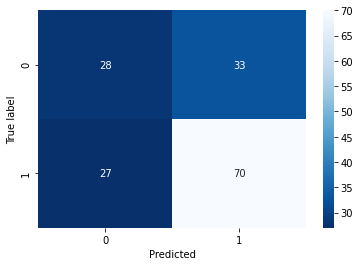

In [103]:
#выведем матрицу
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

При пороге отнесения к классу 0.5 на тестовой выборке получено 33 ложноположительных ответа и 27 ложноотрицательных, 70 коров с вкусным молоком и 28 коров с невкусным молоком определены корректно

## 6.2. Анализ модели

При стандартном пороге классификации 0.5, мы получили следующие метрики:

 - accuracy: процент верных ответов от общего числа ответов - 62%,
 - precision: точность, с которой модель присваивает объектам класс 1 ( не слишком ли часто модель ставит 1 там, где д.б. 0) - 68%,
 - recall: полнота (смогла ли модель присвоить 1 всем объектам этого класса) - 72%.

Поскольку закачику важно получить "вкусное" молоко, то нам важнее ложноположительные ответы свести к нулю,снизить ошибки 1-го рода, т.е. максимизировать precision.

Сведем ошибку 1-го рода к нулю,путем изменения порога принадлежности к классам:

Для этого:
 - выведем числовой расчет класса (y_proba) тестовой выборки,
 - разобьем интервал в виде минимального и максимального значения y_proba на несколько значений,
 - для каждого посчитаем метрики

In [104]:
#выведем расчетное значение вкуса из тестовой выборки
y_proba = clf.predict_proba(X_test)[:,1]

#объединим в одну таблицу с фактическим значением вкуса
y = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)
#выведем таблицу
y

,y_valid,y_proba
17,1,0.87
85,1,0.86
56,1,0.82
77,1,0.82
61,1,0.82
...,...,...
138,1,0.29
88,1,0.28
129,0,0.23
9,0,0.22


In [105]:
#разобьем интвервал y_proba на несколько значений
thresholds = [round(i,2) for i in np.linspace(0.218,0.871,num = 20,endpoint=False)]

# создаём переменную, которая будет хранить список новых колонок
columns = []

# добавим столбцы с новыми предсказаниями в таблицу
for i in thresholds:
    columns.append('y_pred_'+str(i))
    y['y_pred_'+str(i)] = y['y_proba'].apply(lambda x: 0 if x<=i else 1)
y.sample(5)

,y_valid,y_proba,y_pred_0.22,y_pred_0.25,y_pred_0.28,y_pred_0.32,y_pred_0.35,y_pred_0.38,y_pred_0.41,y_pred_0.45,...,y_pred_0.54,y_pred_0.58,y_pred_0.61,y_pred_0.64,y_pred_0.68,y_pred_0.71,y_pred_0.74,y_pred_0.77,y_pred_0.81,y_pred_0.84
82,1,0.53,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45,0,0.39,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
47,1,0.80,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
124,0,0.55,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
123,1,0.50,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


Теперь для каждого значения порога посчитаем метрики

In [106]:
#зададим расчет и вывод значений через цикл
for i in columns:
    accuracy = accuracy_score(y['y_valid'],y[i])
    precision = precision_score(y['y_valid'],y[i])
    recall = recall_score(y['y_valid'],y[i])
    print(f'{i:<12}: accuracy ={accuracy:,.2f}, precision ={precision:,.2f}, recall ={recall:,.2f}')

y_pred_0.22 : accuracy =0.62, precision =0.62, recall =1.00
y_pred_0.25 : accuracy =0.63, precision =0.63, recall =1.00
y_pred_0.28 : accuracy =0.63, precision =0.62, recall =0.99
y_pred_0.32 : accuracy =0.63, precision =0.63, recall =0.97
y_pred_0.35 : accuracy =0.63, precision =0.63, recall =0.93
y_pred_0.38 : accuracy =0.65, precision =0.65, recall =0.92
y_pred_0.41 : accuracy =0.68, precision =0.68, recall =0.91
y_pred_0.45 : accuracy =0.66, precision =0.68, recall =0.84
y_pred_0.48 : accuracy =0.63, precision =0.68, recall =0.77
y_pred_0.51 : accuracy =0.62, precision =0.68, recall =0.71
y_pred_0.54 : accuracy =0.61, precision =0.71, recall =0.62
y_pred_0.58 : accuracy =0.61, precision =0.75, recall =0.56
y_pred_0.61 : accuracy =0.59, precision =0.77, recall =0.48
y_pred_0.64 : accuracy =0.57, precision =0.76, recall =0.43
y_pred_0.68 : accuracy =0.53, precision =0.77, recall =0.34
y_pred_0.71 : accuracy =0.50, precision =0.76, recall =0.27
y_pred_0.74 : accuracy =0.50, precision 

Исходя из посчитанных метрик для каждого порога, минимальный порог принадлежности к классу, при котором precision будет максимальным (равен 1) и который мы будем использовать при прогнозировании оценки вкусности -это  0.81.
Следующий порог по точности-это значение precision=0.82, для этого значения порог отнесения к классу равен 0.74.

При этом стоит отметить, что порог для получения максимального кол-ва верных ответов от всех (максимальный accuracy) - это порог в 0.41, для получения максимального recall - это 0.25


Посчитаем матрицу с порогом 0.81.

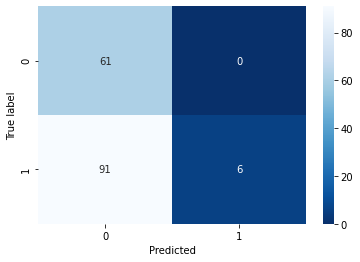

In [107]:
cm = confusion_matrix(y['y_valid'],y['y_pred_0.81'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

При пороге отнесения к "вкусному" молоку 0.81 на тестовой выборке ошибки первого рода отсутствуют, при этом второго составляют 94%. Всего 6 коров с вкусным молоком и 61 корова с невкусным определены корректно,вкус молока 91 коровы был ложно отнесен к невкусному.

При прогнозировании с целью максимального точного определения именно "вкусного" молока будет использоваться порог отнесения к вкусному 0.81.

## 6.3. Прогноз для модели

Спрогнозируем вкус молока.
Заново создадим нужную нам таблицу из данных Экофермы

In [108]:
# зададим столбцы,значения которых будем добавлять
new = ['efu','raw_protein','spr']
taste = cow
#добавим эти столбцы средними значениями данных фермы с учетом 5%-ного увеличения
for i in new:
    taste[i] = ferma_m[i].mean()*1.05
#переименуем столбцы с текущим процентом жирности и молока
taste = taste.rename(
    columns={'current_fat_percent': 'fat_percent','current_protein_percent':'protein_percent'}
)
#удалим признаки порода коровы и порода отца коровы
taste = taste.drop(['kind','kind_of_dad'],axis=1)
#выведем полученную таблицу
taste.head()

,pasture,dad_name,fat_percent,protein_percent,age,efu,raw_protein,spr
0,холмистое,Геркулес,3.58,3.08,более_2_лет,15.27,"2,019.53",0.96
1,равнинное,Буйный,3.54,3.08,менее_2_лет,15.27,"2,019.53",0.96
2,равнинное,Барин,3.59,3.07,более_2_лет,15.27,"2,019.53",0.96
3,холмистое,Буйный,3.40,3.06,более_2_лет,15.27,"2,019.53",0.96
4,равнинное,Буйный,3.64,3.07,более_2_лет,15.27,"2,019.53",0.96


In [109]:
#зададим названия категориальных и количественных признаков: 
categor = ['pasture','age','dad_name']
numeric = ['efu','raw_protein','protein_percent','spr','fat_percent']

#трансформируем количественные признаки
taste_scaled = scaler.transform(taste[numeric])

#выбор метода кодирования, его инициализация
encoder = OneHotEncoder(drop = 'first', sparse = False)

#трансформируем категориальные признаки
taste_ohe = encoder.fit_transform(taste[categor])

# получим от кодировщика список новых столбцов и сохраним в новой переменной 
encoder_col_names = encoder.get_feature_names()

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
# для данных OHE названия столбцов укажем из переменной encoder_col_names
taste_ohe = pd.DataFrame(taste_ohe, columns=encoder_col_names)
taste_scaled = pd.DataFrame(taste_scaled, columns=numeric)

# объединяем все преобразованные данные в датафрейм
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок
taste = pd.concat([taste_ohe, taste_scaled], axis=1)

# вывод таблицы после стандартизации и кодирования
taste.head()

,x0_холмистое,x1_менее_2_лет,x2_Буйный,x2_Геркулес,x2_Соловчик,efu,raw_protein,protein_percent,spr,fat_percent
0,1.00,0.00,0.00,1.00,0.00,0.55,0.54,0.13,1.40,-0.17
1,0.00,1.00,1.00,0.00,0.00,0.55,0.54,2.05,1.40,-0.41
2,0.00,0.00,0.00,0.00,0.00,0.55,0.54,-0.63,1.40,-0.11
3,1.00,0.00,1.00,0.00,0.00,0.55,0.54,-5.61,1.40,-1.27
4,0.00,0.00,1.00,0.00,0.00,0.55,0.54,-0.63,1.40,0.20


In [110]:
# получим предсказания модели на тестовых данных 
# сохраним результат
y_pred = clf.predict(taste)
y_pred

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1])

При пороге в 0.5 модель молоко  80% от всего прогноза оценивает как вкусное.

Оценим вкус при изменении порога отнесения к классу:
 - на 0.81 (максимальная точность определения вкусного молока - 100%) - интересующие нас значения, 
 - на 0.74 (точность определения вкуса молока 82%),
 - на 0.68 (точность определения вкуса молока 77%),
 - на 0.41(максимальный процент верных ответов от общего числа - 68%),
 - на 0.25 (сведение ложноотрицательных ответов к нулю)

In [111]:
#выведем расчетное значение класса вкуса из прогнозной выборки
y_proba = clf.predict_proba(taste)[:,1]

#объединим в одну таблицу с предсказанным значением вкуса
y = pd.DataFrame(zip(y_pred, y_proba),
             columns = ['y_valid', 'y_proba'])

#создадим столбец с вкусом молока с разными порогами для отнесения к вкусному молоку
y['max_precision_0.81'] = y['y_proba'].apply(lambda x: 'вкусно' if x>=0.81 else 'не вкусно')
y['precision=0.82_0.74'] = y['y_proba'].apply(lambda x: 'вкусно' if x>=0.74 else 'не вкусно')
y['precision=0.77_0.68'] = y['y_proba'].apply(lambda x: 'вкусно' if x>=0.68 else 'не вкусно')
y['max_accuracy_0.41'] = y['y_proba'].apply(lambda x: 'вкусно' if x>=0.41 else 'не вкусно')
y['max_recall_0.25'] = y['y_proba'].apply(lambda x: 'вкусно' if x>=0.25 else 'не вкусно')


# выведем всю таблицу
y

,y_valid,y_proba,max_precision_0.81,precision=0.82_0.74,precision=0.77_0.68,max_accuracy_0.41,max_recall_0.25
0,1,0.77,не вкусно,вкусно,вкусно,вкусно,вкусно
1,1,0.72,не вкусно,не вкусно,вкусно,вкусно,вкусно
2,1,0.70,не вкусно,не вкусно,вкусно,вкусно,вкусно
3,1,0.56,не вкусно,не вкусно,не вкусно,вкусно,вкусно
4,1,0.58,не вкусно,не вкусно,не вкусно,вкусно,вкусно
5,0,0.32,не вкусно,не вкусно,не вкусно,не вкусно,вкусно
6,1,0.77,не вкусно,вкусно,вкусно,вкусно,вкусно
7,1,0.67,не вкусно,не вкусно,не вкусно,вкусно,вкусно
8,1,0.70,не вкусно,не вкусно,вкусно,вкусно,вкусно
9,1,0.81,вкусно,вкусно,вкусно,вкусно,вкусно


Коровы, молоко которых со 100%-ной вероятностью будет вкусным (столбец max_precision_0.81): это 10-я и 14-я коровы по списку.

Мы получили следующее:
 - столбец max_precision_0.81: при пороге 0.81 значение precision будет максимальным (равное 1), т.е. ошибки 1-го рода будут отсутствовать. Это значит, что при данном значении порога отнесения молока к вкусному, вероятность определить именно вкусное молоко составляет 100%. Для данного порога вкусным является молоко 10-й и 14-й по списку коров.
 - столбец precision=0.82_0.74: при пороге 0.74 вероятность определить именно вкусное молоко составит 82%, т.е. вероятность купить корову с невкусным молоком составляет 18%. К определенным выше 10-й и 14-й коровам в качестве вкусных определяются также 1-я и 7-я по списку коровы: у 10-й и 14-й коров молоко точно будет вкусным, а вот у 1-й и 7-й вероятность получить вкусное молоко уже меньше - поэтому если потребуется, например, купить больше 2-х коров с вкусным молоком, то поскольку по этим 1-й и 7-й коровам 100%-ной уверенности по вкусе нет - по ним можно попросить скидку.
 - столбец precision=0.77_0.68: при пороге 0.68 вероятность определить именно вкусное молоко составит еще меньше 77%, т.е. вероятность купить корову с невкусным молоком составляет 23%. К определенным выше коровам в качестве вкусных определяются также 2-я, 3-я,9-я и 17-я:у 10-й и 14-й коров молоко точно будет вкусным, у 1-й и 7-й вероятность получить вкусное молоко уже меньше, а для 2, 3,9-й и 17-й - вероятность получить вкусное еще меньше, поэтому скидка по этим 4-м коровам может быть еще выше, чем по 1-й и 7-й. 

Дополнительно приведена информация о порогах определении вкуса молока, если цели изменятся:
 - если требуется максимально возможно со стороны модели получить верную оценку вкуса молока (неважно какого вкуса),т.е. максимизировать accuracy (для данной модели максимальное значение параметра составляет 0.68), то порог отнесения к классу необходио выбрать 0.41: для данного порога вероятност определить корректный вкус молока будет 68%, для данного порога только у 4-х коров молоко определяется невкусным,
 - если требуется не упустить ни одной коровы с вкусным молоком, т.е. свести ложноотрицательные ответы к нулю (максимизировать recall), то порог для отнесения к классу должен быть приравнен к 0.25



# 7.Итоговые выводы

Добавим прогноз удоя и вкуса молока в данные Экофермы с учетом моделей линейной регресии и классификации

In [112]:
#добавим столбцы в прогнозный датасет
cow['yeild'] = prognoz['yeild']
cow['taste'] = y['max_precision_0.81']
#выведем прогнозный датасет с данными об удоях и вкусе
cow

,kind,pasture,kind_of_dad,dad_name,current_fat_percent,current_protein_percent,age,efu,raw_protein,spr,yeild,taste
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет,15.27,"2,019.53",0.96,"6,365.69",не вкусно
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.08,менее_2_лет,15.27,"2,019.53",0.96,"6,026.63",не вкусно
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.07,более_2_лет,15.27,"2,019.53",0.96,"6,043.75",не вкусно
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.06,более_2_лет,15.27,"2,019.53",0.96,"6,479.23",не вкусно
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.07,более_2_лет,15.27,"2,019.53",0.96,"6,318.38",не вкусно
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.05,менее_2_лет,15.27,"2,019.53",0.96,"6,236.04",не вкусно
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет,15.27,"2,019.53",0.96,"6,365.69",не вкусно
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.08,более_2_лет,15.27,"2,019.53",0.96,"6,255.44",не вкусно
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.07,более_2_лет,15.27,"2,019.53",0.96,"6,043.75",не вкусно
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.08,менее_2_лет,15.27,"2,019.53",0.96,"6,143.57",вкусно


С учетом пересмотра подходов к кормлению (увеличению СПО, ЭКЕ и сырого протеина) практически все коровы, за исключением 14-й, будут давать удои свыше 6000 кг в год.

Выведем перечень коров, которые соответствуют условию - удои выше 6000 кг в год и молоко вкусное

In [113]:
cow.query('yeild >=6000 and taste=="вкусно"')

,kind,pasture,kind_of_dad,dad_name,current_fat_percent,current_protein_percent,age,efu,raw_protein,spr,yeild,taste
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.08,менее_2_лет,15.27,"2,019.53",0.96,"6,143.57",вкусно


Удои свыше 6000 кг и вкусное молоко даст только 10-я по списку корова: это корова породы РефлешнСоверинг,которая  паслась на холмистом пастбище, порода отца - Айдал, кличка - Буйный, текущий процент жирности молока - 3.4%, процент белка в молоке - 3.08%, возрастом менее 2-х лет.

Мы помним также, что для используемой модели линейной регресси, по которой мы рассчитали удои, метрика MAE =145.6:  прогнозное значение удоя в среднем отличается от истинного на 145.6 кг. С учетом консерватизма, вычтем из прогнозного значения удоев 145.6 кг и посмотрим какой будет удой у 10-й коровы.

In [114]:
cow['yeild_corr'] = cow['yeild'] - 145.6
cow[['yeild','yeild_corr','taste']].query('yeild >=6000 and taste=="вкусно"')

,yeild,yeild_corr,taste
9,"6,143.57","5,997.97",вкусно


Даже консервативное скорректированное на MAE значение удоев 10-й коровы практически равно требуемому 6000 кг.

Для прогнозирования удоев и вкуса были обучены 2 модели соответственно: линейная регрессия и классификация. В каждой модели были определены влияющие на удой и вкус признаки. 

Для линейной модели оценка качества проведена путем ряда показателей:
 - значение коэф-та детерминации R2  - 0.88: 88% предсказаний модели ближе к истине, чем среднее значение удоев,
 - прогнозное значение удоя в среднем отличается от истинного на 145.6 кг,
 - распределение остатков является симметричным (модель даёт как завышенные, так и заниженные предсказания, которые «уравновешивают» друг друга),дисперсия остатков близка к постоянной.
 
Для оценки вкуса молока в модели классификации минимизированы ошибки 1-го рода, т.е. ошибочное признание молока вкусным: т.е. если молоко признано вкусным, то вероятность этого 100%. При этом ошибки 2-го рода, т.е. ошибочного признания молока невкусным, составляет 94%, т.е. вероятность признания вкусного молока невкусным и упустить корову с вкусным молоком крайне высокая. 

Таким образом:
 - исходя из задачи с минимальным риском приобрести корову, которая гарантированно будет давать удои свыше 6000 кг и иметь вкусное молоко, из представленных данных Экофермы подходит только 10-я по списку корова:это корова породы РефлешнСоверинг,которая паслась на холмистом пастбище, порода отца - Айдал, кличка - Буйный, текущий процент жирности молока - 3.4%, процент белка в молоке - 3.08%, возрастом менее 2-х лет.
 - она подходит только при заявленном пересмотре подходов к питанию в части СПО, ЭКЕ и сырого протеина,
 - если удои свыше 6000 кг будут более важны, чем вкус: то подойдут все коровы, кроме 14-й по списку; если важно точно купить корову с вкусным молоком, невзирая, на уровень удоя, то подойдут 10-я и 14-я коровы.
 - если при удоях свыше 6000 кг требуется купить более одной коровы с вкусным молоком (например, три коровы): в этом случае можно купить 10-ю корову со 100%-ной вероятностью получения вкусного молока, а также купить 1-ю и 7-ю корову по списку и попросить по ним скидку, т.к. вероятность получения  от них вкусного молока наиболее велика, но тем не менее не 100%-ная,
 - если станет важнее не упустить корову с вкусным молоком (снизить ошибки 2-го рода до нуля), то порог для отнесения к вкусному молоку нужно будет снизить до 0.25; если важно как можно точнее определить будет ли молоко вкусным или нет - порог нужно установить в 0.41.

Выводы о моделях линейной регрессии и логистической регрессии:
 - для улучшения качества регрессионной модели в данном проекте использованы метод трансформации текущих входных признаков (для линейной регрессии - для устранения нелинейной зависимости), добавлены дополнительные неучтенные признаки (имена коров отцов);
 - поскольку анализ остатков в линейной модели показывает недостаточную "нормальность" распределения остатков, то модель может еще быть улучшена - возможно есть еще какие-то неучтенные дополнительные признаки (например, порода или имена матерей коров). Также стоит отметить, что корреляция удоев и возраста максимальная по сравнению с прочими признаками, но в данных от фермы коров с возрастом более 2-х лет почти в 5 раз больше, чем с возрастом менее 2-х лет -  с учетом возраста выборка не совсем репрезентативна, при другом соотношении коров по возрасту модель может работать по-другому. Поэтому модель также может быть доработана при изменении соотношения коров по возрасту;
 - важные метрики моделей классификации, в том числе логистической регрессии, при анализе рисков или экономических расчётов: accuracy (процент верных ответов от общего числа ответов) показывает общую точность модели при заданном пороге отнесения к классу, при этом зачастую требуется настроить модель таким образом, чтобы она максимально точно определяла один класс, либо максимально точно определяла, что прогнозное значение не будет к этому классу отнесено. В этом случае, в зависимости от задачи,  нужно  либо снизить кол-во ложноположительных ответов до нуля (снизить кол-во ошибок 1-го рода) - нужно отталкиваться от метрики precision, либо снизить кол-во ложноотрицательных ответов до нуля- нужно отталкиваться от метрики recall.